In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")


client = OpenAI(
    api_key=os.getenv("OPENAI_KEY"),
)

MODEL_NAME = "gpt-4o"

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-08-14 12:28:34 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-08-14 12:28:34 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-08-14 12:28:34 __main__ INFO     transformers.__version__='4.43.3'
2024-08-14 12:28:34 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2024-08-14 12:28:34 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'


In [3]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

# model_key = "meta-llama/Meta-Llama-3-8B"
model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-08-14 12:28:35 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

2024-08-14 12:28:41 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [4]:
from src.utils.typing import TokenizerOutput
from src.functional import get_module_nnsight, untuple, get_hs, PatchSpec
from typing import Literal
from dataclasses import dataclass
from src.functional import free_gpu_cache

#! the clean here actually stands for **corrupt* in the causal tracing
def attribution_patching(
    mt: ModelandTokenizer,
    clean_inputs: TokenizerOutput,
    patches: PatchSpec | list[PatchSpec],
    interested_locations: list[tuple[str, int]],
    ans_token_idx: int,
    metric: Literal["logit", "proba"] = "proba",
    resolution: int = 10,
    intermediate_point_sample: Literal["linear", "non-linear"] = "non-linear",
) -> float:

    if "offset_mapping" in clean_inputs:
        clean_inputs.pop("offset_mapping")
    if isinstance(patches, PatchSpec):
        patches = [patches]

    clean_states = get_hs(
        mt = mt, 
        input = clean_inputs,
        locations = interested_locations,
        return_dict=True
    )
    patched_states = get_hs(
        mt = mt, 
        input = clean_inputs,
        locations = interested_locations,
        patches = patches,
        return_dict=True
    )
    free_gpu_cache()

    scan = True

    @dataclass
    class IGCache:
        h: torch.Tensor
        grad: torch.Tensor

        def __post_init__(self):
            self.h.shape == self.grad.shape

    def is_an_attn_head(module_name) -> bool | tuple[int, int]:
        attn_id = mt.attn_module_name_format.split(".")[-1]
        if attn_id not in module_name:
            return False
        if module_name.endswith(attn_id):
            return False
        
        head_id = module_name.split(".")[-1]
        layer_id = ".".join(module_name.split(".")[:-1])
        
        return layer_id, int(head_id)


    approx_IE = {loc: [] for loc in interested_locations}
    alphas = torch.linspace(0, 1, resolution+1)

    for a_idx in tqdm(range(len(alphas)-1)):
        alpha = alphas[a_idx]

        with mt.trace(clean_inputs, scan=scan, validate=scan) as tracer:
            # patching
            for patch in patches:
                module_name, tok_idx = patch.location
                patch_module = get_module_nnsight(mt, module_name)

                assert isinstance(patch.clean, torch.Tensor) and patch.clean.shape == patch.patch.shape
                mid_point = (1 - alpha) * patch.clean + alpha * patch.patch
                mid_point = mid_point.to(mt.device) if not mid_point.device == mt.device else mid_point
                mid_point.retain_grad = True

                patch_module.output[0, tok_idx, :] = mid_point

            # cache the interested hidden states
            for loc in interested_locations:
                module_name, tok_idx = loc

                if is_an_attn_head(module_name) == False:
                    module = get_module_nnsight(mt, module_name)
                    cur_output = (
                        module.output.save()
                        if ("mlp" in module_name or module_name == mt.embedder_name)
                        else module.output[0].save()
                    )   #! nnsight quirk => to get the grad of a reference tensor, you can't index it
                    approx_IE[loc].append(
                        IGCache(
                            h = cur_output[0, tok_idx, :].save(),
                            grad = cur_output.grad[0, tok_idx, :].save()
                        )
                    )
                else:
                    attn_module_name, head_idx = is_an_attn_head(module_name)
                    o_proj_name = attn_module_name + ".o_proj"
                    head_dim = mt.n_embd // mt.model.config.num_attention_heads
                    o_proj = get_module_nnsight(mt, o_proj_name)
                    cur_input = o_proj.input[0][0][
                        :, :, head_idx * head_dim : (head_idx + 1) * head_dim
                    ].save()
                    # tracer.apply(logger.debug, cur_input.size())

                    approx_IE[loc].append(
                        IGCache(
                            h = cur_input[0, tok_idx, :].save(),
                            grad = o_proj.input[0][0][
                                0, tok_idx, head_idx * head_dim : (head_idx + 1) * head_dim
                            ].save()
                        )
                    )

            #! nnsight quirk => backward() has to be called later than grad.save() to populate the proxies
            if metric == "logit":
                v = mt.output.logits[0][-1][ans_token_idx]
            elif metric == "proba":
                v = mt.output.logits[0][-1].softmax(dim=-1)[ans_token_idx]
            else:
                raise ValueError(f"unknown {metric=}")
            v.backward()

        mt._model.zero_grad()
        scan = False
        free_gpu_cache()

    grads = {loc: sum([ig.grad for ig in approx_IE[loc]]) / resolution for loc in interested_locations}

    if intermediate_point_sample == "linear":
        approx_IE = {
            loc: torch.dot(grad, patched_states[loc] - clean_states[loc]).item() 
            for loc, grad in grads.items()
        } 
    elif intermediate_point_sample == "non-linear":
        for loc in interested_locations:
            ie_approx = 0
            for a_idx in range(len(alphas)-1):
                grad = approx_IE[loc][a_idx].grad
                h_0 = approx_IE[loc][a_idx].h
                h_next = approx_IE[loc][a_idx+1].h if a_idx < len(alphas)-2 else patched_states[loc]

                ie_approx += torch.dot(grad, h_next - h_0).item()
            
            approx_IE[loc] = ie_approx
    else:
        raise ValueError(f"unknown {intermediate_point_sample=}")

    return approx_IE

In [5]:
from src.functional import prepare_input, guess_subject
from src.functional import find_token_range, get_hs
from typing import Optional

def get_h_at_subj(
    mt: ModelandTokenizer,
    layer: str | list[str],
    prompt: str | TokenizerOutput,
    subj: Optional[str] = None,
    input: Optional[TokenizerOutput] = None,
) -> torch.Tensor:
    if subj is None:
        subj = guess_subject(prompt)
        logger.warning(f"no subj provided, guessed {subj=}")
    else:
        assert subj in prompt, f"{subj=} not in {prompt=}"

    skip_prepare_input = input is not None and "offset_mapping" in input
    if not skip_prepare_input:
        logger.debug(f"preparing input for prompt: {prompt}")
        input = prepare_input(
            prompts=prompt, 
            tokenizer=mt, 
            return_offsets_mapping=True
        )
    offset_mapping = input.pop("offset_mapping")[0]
    subj_range = find_token_range(string=prompt, substring=subj, tokenizer=mt.tokenizer, offset_mapping=offset_mapping)
    subj_ends = subj_range[1] - 1

    logger.debug(f"{subj=} => {subj_ends=} | \"{mt.tokenizer.decode(input['input_ids'][0][subj_ends])}\"")

    return get_hs(
        mt = mt, input = input, 
        locations = [(l, subj_ends) for l in layer]
    )

In [6]:
from src.dataset import load_bridge_relation, BridgeDataset

relation_icq = load_bridge_relation(
    file_name="/home/local_arnab/Codes/retrieval/data/bridge_dataset/cleaned/movie_actor.json"
)

dataset = BridgeDataset(
    relations = [relation_icq]
)

2024-08-14 12:28:41 src.dataset INFO     initialized bridge relation movie_actor with 52 examples
2024-08-14 12:28:41 src.dataset INFO     initialized bridge dataset with 1 relations and 51 examples


In [7]:
clean_idx = 10
patch_idx = 22

clean_icq = dataset[clean_idx]
patch_icq = dataset[patch_idx]

print(f"{dataset.icl_examples=}")
print(f"{dataset.examples[clean_idx]=}")
print(f"{dataset.examples[patch_idx]=}")

dataset.icl_examples=[BridgeSample(bridge='The Hurricane', entity_pair=['Denzel Washington', 'Rubin "Hurricane" Carter'], description='The Hurricane - a movie where Denzel Washington played the role of Rubin "Hurricane" Carter.')]
dataset.examples[clean_idx]=BridgeSample(bridge='The Blind Side', entity_pair=['Sandra Bullock', 'Leigh Anne Tuohy'], description='The Blind Side - a movie where Sandra Bullock played the role of Leigh Anne Tuohy.')
dataset.examples[patch_idx]=BridgeSample(bridge='Into the Wild', entity_pair=['Emile Hirsch', 'Christopher McCandless'], description='Into the Wild - a movie where Emile Hirsch played the role of Christopher McCandless.')


In [8]:
from src.functional import predict_next_token

clean_ans = predict_next_token(mt = mt, inputs = clean_icq[0])[0][0]
print(f"{clean_ans=}")

patch_ans = predict_next_token(mt = mt, inputs = patch_icq[0])[0][0]
print(f"{patch_ans=}")

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


clean_ans=PredictedToken(token=' The', prob=0.9427220821380615, token_id=tensor(578, device='cuda:0'))
patch_ans=PredictedToken(token=' Into', prob=0.9641967415809631, token_id=tensor(32745, device='cuda:0'))


In [9]:
from src.functional import predict_next_token
from src.trace import insert_padding_before_subj


clean_inputs = prepare_input( 
    prompts = clean_icq[0],
    tokenizer = mt,
    return_offsets_mapping=True
)
clean_offsets = clean_inputs.pop("offset_mapping")[0]
clean_subj_ranges = [
    find_token_range(
        string = clean_icq[0],
        substring = subj,
        tokenizer = mt.tokenizer,
        offset_mapping = clean_offsets,
    ) for subj in dataset.examples[clean_idx].entity_pair
]
logger.debug(f"{clean_subj_ranges=}")
for t in range(*clean_subj_ranges[0]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][t])}")
logger.debug(f"{'-'*50}")
for t in range(*clean_subj_ranges[1]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][t])}")
logger.debug(f"{'='*50}")

patch_inputs = prepare_input(
    prompts = patch_icq[0],
    tokenizer = mt,
    return_offsets_mapping=True
)
patch_offsets = patch_inputs.pop("offset_mapping")[0]
patch_subj_ranges = [
    find_token_range(
        string = patch_icq[0],
        substring = subj,
        tokenizer = mt.tokenizer,
        offset_mapping = patch_offsets,
    ) for subj in dataset.examples[patch_idx].entity_pair
]
logger.debug(f"{patch_subj_ranges=}")
for t in range(*patch_subj_ranges[0]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(patch_inputs['input_ids'][0][t])}")
logger.debug("-"*50)
for t in range(*patch_subj_ranges[1]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(patch_inputs['input_ids'][0][t])}")

logger.debug(f"{'+'*50}")

assert clean_subj_ranges[0][0] == patch_subj_ranges[0][0]
subj_1_range = (
    clean_subj_ranges[0][0],
    max(clean_subj_ranges[0][1], patch_subj_ranges[0][1])
)
clean_inputs = insert_padding_before_subj(
    clean_inputs, clean_subj_ranges[0], subj_1_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)
patch_inputs = insert_padding_before_subj(
    patch_inputs, patch_subj_ranges[0], subj_1_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)

clean_subj2_shift = subj_1_range[1] - clean_subj_ranges[0][1]
clean_subj_ranges[1] = (
    clean_subj_ranges[1][0] + clean_subj2_shift, 
    clean_subj_ranges[1][1] + clean_subj2_shift
)
patch_subj2_shift = subj_1_range[1] - patch_subj_ranges[0][1]
patch_subj_ranges[1] = (
    patch_subj_ranges[1][0] + patch_subj2_shift, 
    patch_subj_ranges[1][1] + patch_subj2_shift
)

subj_2_range = (
    max(clean_subj_ranges[1][0], patch_subj_ranges[1][0]),
    max(clean_subj_ranges[1][1], patch_subj_ranges[1][1])
)
clean_inputs = insert_padding_before_subj(
    clean_inputs, clean_subj_ranges[1], subj_2_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)
patch_inputs = insert_padding_before_subj(
    patch_inputs, patch_subj_ranges[1], subj_2_range[1],
    pad_id = mt.tokenizer.pad_token_id, fill_attn_mask=True
)


# for idx, (t1, a1, t2, a2) in enumerate(zip(
#     clean_inputs.input_ids[0], clean_inputs.attention_mask[0],
#     patch_inputs.input_ids[0], patch_inputs.attention_mask[0],
# )):
#     is_subj = idx in range(subj_1_range[0], subj_1_range[1]) or idx in range(subj_2_range[0], subj_2_range[1])
#     append = "*" if is_subj else ""
#     print(f"{idx=} >> [{a1}] {mt.tokenizer.decode(t1)}{append} | [{a2}] {mt.tokenizer.decode(t2)}{append}")

logger.debug(f"{subj_1_range=}")
for i in range(*subj_1_range):
    logger.debug(f"{i=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][i])} <> {mt.tokenizer.decode(patch_inputs['input_ids'][0][i])}")
logger.debug(f"{'-'*50}")
logger.debug(f"{subj_2_range=}")
for i in range(*subj_2_range):
    logger.debug(f"{i=} | [{clean_inputs['attention_mask'][0][i]}]{mt.tokenizer.decode(clean_inputs['input_ids'][0][i])} <> [{patch_inputs['attention_mask'][0][i]}]{mt.tokenizer.decode(patch_inputs['input_ids'][0][i])}")
logger.debug(f"{'='*50}")

2024-08-14 12:28:42 __main__ DEBUG    clean_subj_ranges=[(59, 62), (63, 68)]
2024-08-14 12:28:42 __main__ DEBUG    t=59 |  Sandra
2024-08-14 12:28:42 __main__ DEBUG    t=60 |  Bul
2024-08-14 12:28:42 __main__ DEBUG    t=61 | lock
2024-08-14 12:28:42 __main__ DEBUG    --------------------------------------------------
2024-08-14 12:28:42 __main__ DEBUG    t=63 |  Leigh
2024-08-14 12:28:42 __main__ DEBUG    t=64 |  Anne
2024-08-14 12:28:42 __main__ DEBUG    t=65 |  Tu
2024-08-14 12:28:42 __main__ DEBUG    t=66 | oh
2024-08-14 12:28:42 __main__ DEBUG    t=67 | y
2024-08-14 12:28:42 __main__ DEBUG    ==================================================
2024-08-14 12:28:42 __main__ DEBUG    patch_subj_ranges=[(59, 63), (64, 68)]
2024-08-14 12:28:42 __main__ DEBUG    t=59 |  Em
2024-08-14 12:28:42 __main__ DEBUG    t=60 | ile
2024-08-14 12:28:42 __main__ DEBUG    t=61 |  H
2024-08-14 12:28:42 __main__ DEBUG    t=62 | irsch
2024-08-14 12:28:42 __main__ DEBUG    ---------------------------------

In [10]:
clean_ans = predict_next_token(
    mt = mt,
    inputs = clean_inputs,
)[0][0]
logger.debug(f"{clean_ans=}")

patch_ans = predict_next_token(
    mt = mt,
    inputs = patch_inputs,
)[0][0]
logger.debug(f"{patch_ans=}")

2024-08-14 12:28:42 __main__ DEBUG    clean_ans=PredictedToken(token=' The', prob=0.9710718393325806, token_id=tensor(578, device='cuda:0'))
2024-08-14 12:28:42 __main__ DEBUG    patch_ans=PredictedToken(token=' Into', prob=0.9771255254745483, token_id=tensor(32745, device='cuda:0'))


In [11]:
emb_clean = get_hs(
    mt = mt, 
    input = clean_inputs,
    locations = [(
        mt.embedder_name, tok_idx) for tok_idx in 
        list(range(*subj_1_range)) + list(range(*subj_2_range))
    ]
)

emb_patch = get_hs(
    mt = mt, 
    input = patch_inputs,
    locations = [(
        mt.embedder_name, tok_idx) for tok_idx in 
        list(range(*subj_1_range)) + list(range(*subj_2_range))
    ]
)

for key in emb_clean.keys():
    print(f"{key=} | {emb_clean[key].norm().item()=} | {emb_patch[key].norm().item()=}")

key=('model.embed_tokens', 59) | emb_clean[key].norm().item()=0.03955078125 | emb_patch[key].norm().item()=0.5537109375
key=('model.embed_tokens', 60) | emb_clean[key].norm().item()=0.6904296875 | emb_patch[key].norm().item()=0.448974609375
key=('model.embed_tokens', 61) | emb_clean[key].norm().item()=0.61669921875 | emb_patch[key].norm().item()=0.408447265625
key=('model.embed_tokens', 62) | emb_clean[key].norm().item()=0.49072265625 | emb_patch[key].norm().item()=0.638671875
key=('model.embed_tokens', 64) | emb_clean[key].norm().item()=0.6357421875 | emb_patch[key].norm().item()=0.03955078125
key=('model.embed_tokens', 65) | emb_clean[key].norm().item()=0.58984375 | emb_patch[key].norm().item()=0.64404296875
key=('model.embed_tokens', 66) | emb_clean[key].norm().item()=0.58056640625 | emb_patch[key].norm().item()=0.64501953125
key=('model.embed_tokens', 67) | emb_clean[key].norm().item()=0.473388671875 | emb_patch[key].norm().item()=0.408935546875
key=('model.embed_tokens', 68) | emb

In [12]:
mt.layer_names[-1], clean_inputs.input_ids[0][-1]

('model.layers.31', tensor(25, device='cuda:0'))

In [13]:
patch_spec = [
    PatchSpec(
        location = location,
        patch = emb_patch[location],
        clean = emb_clean[location],
    ) for location in emb_clean.keys()
]

subj2_last_idx = subj_2_range[1] - 1
prompt_last_idx = clean_inputs.input_ids.shape[1] - 1
test_h = get_hs(
    mt=mt,
    input=clean_inputs,
    locations=[
        (mt.embedder_name, subj2_last_idx),
        (mt.layer_names[-1], prompt_last_idx)
    ],
    patches=patch_spec,
)

torch.allclose(emb_patch[(mt.embedder_name, subj2_last_idx)], test_h[(mt.embedder_name, subj2_last_idx)])

True

In [14]:
from src.functional import logit_lens

logit_lens(
    mt = mt,
    h = test_h[(mt.layer_names[-1], prompt_last_idx)],
    get_proba=True
)

[(' Into', 0.977),
 (' The', 0.012),
 (' INTO', 0.002),
 (' Sean', 0.001),
 (' Chris', 0.001),
 ('Into', 0.001),
 (' "', 0.001),
 (' In', 0.0),
 (' Based', 0.0),
 (' Christopher', 0.0)]

In [15]:
clean_inputs

{'input_ids': tensor([[128000,  22818,   1403,  15086,     11,   1505,    264,   4279,   2723,
           1990,   1124,    627,   5062,   3923,    374,    264,   4279,   2723,
           1990,   9973,  28493,   6652,    323,  83026,    330,  98428,  26108,
              1,  25581,   5380,     32,     25,    578,  38201,    482,    264,
           5818,   1405,   9973,  28493,   6652,   6476,    279,   3560,    315,
          83026,    330,  98428,  26108,      1,  25581,    627,   5062,   3923,
            374,    264,   4279,   2723,   1990, 128009,  56786,  13805,   1039,
            323,  74122,  29026,  29749,   2319,     88,   5380,     32,     25]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

In [16]:
query_start = find_token_range(
    string = clean_icq[0],
    substring = "#",
    tokenizer = mt.tokenizer,
    offset_mapping = clean_offsets,
    occurrence=-1
)[-1]

In [17]:
query_start

53

In [18]:
# locations = [(mt.embedder_name, tok_idx) for tok_idx in range(clean_inputs.input_ids.shape[1])]
# module_template = mt.attn_module_name_format

locations = []
for l_idx in range(mt.n_layer):
    for tok_idx in range(query_start, clean_inputs.input_ids.shape[1]):
        locations.append((mt.layer_name_format.format(l_idx), tok_idx))
        locations.append((mt.mlp_module_name_format.format(l_idx), tok_idx))
        locations.append((mt.attn_module_name_format.format(l_idx), tok_idx))

        for h_idx in range(mt.model.config.num_attention_heads):
            locations.append((mt.attn_module_name_format.format(l_idx) + f".{h_idx}", tok_idx))

# locations

In [19]:
from tqdm.auto import tqdm

def is_an_attn_head(module_name) -> bool | tuple[int, int]:
    attn_id = mt.attn_module_name_format.split(".")[-1]
    if attn_id not in module_name:
        return False
    if module_name.endswith(attn_id):
        return False
    
    head_id = module_name.split(".")[-1]
    layer_id = ".".join(module_name.split(".")[:-1])
    
    return layer_id, int(head_id)

for module_name, tok_idx in tqdm(locations):
    # module = get_module_nnsight(mt, module_name)
    # logger.debug(f"{module_name=}")
    if is_an_attn_head(module_name) == False:
        module = get_module_nnsight(mt, module_name)
    else:
        attn_module_name, head_idx = is_an_attn_head(module_name)
        o_proj_name = attn_module_name + ".o_proj"
        o_proj = get_module_nnsight(mt, o_proj_name)

100%|██████████| 21280/21280 [00:00<00:00, 375621.43it/s]


In [20]:
results = attribution_patching(
    mt = mt,
    clean_inputs = clean_inputs,
    patches = patch_spec,
    interested_locations=locations,
    ans_token_idx=patch_ans.token_id,
)

100%|██████████| 10/10 [03:25<00:00, 20.51s/it]


In [31]:
from src.trace import get_window

# module_template = mt.layer_name_format
# module_template = mt.mlp_module_name_format
module_template = mt.attn_module_name_format
window_size = 1

trace_start_idx = query_start
approx_effects = torch.zeros(
    len(range(trace_start_idx, clean_inputs.input_ids.shape[1])), 
    mt.n_layer
)

for l in range(mt.n_layer):
    for t in range(trace_start_idx, clean_inputs.input_ids.shape[1]):
        if window_size == 1:
            approx_effects[t - trace_start_idx, l] = results[(module_template.format(l), t)]
        else:
            approx_effects[t - trace_start_idx, l] = sum([
                results[(module, t)] 
                for module in get_window(module_template, l, window_size, mt.n_layer)
            ])
            
approx_effects.shape

torch.Size([19, 32])

In [32]:
# len([mt.tokenizer.decode(tok) for tok in clean_inputs.input_ids[0][trace_start_idx:]])
len([mt.tokenizer.decode(tok) for tok in patch_inputs.input_ids[0][trace_start_idx:]])

19

2024-08-14 12:42:49 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f2a224b01d0>
2024-08-14 12:42:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-14 12:42:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-14 12:42:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-14 12:42:49 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


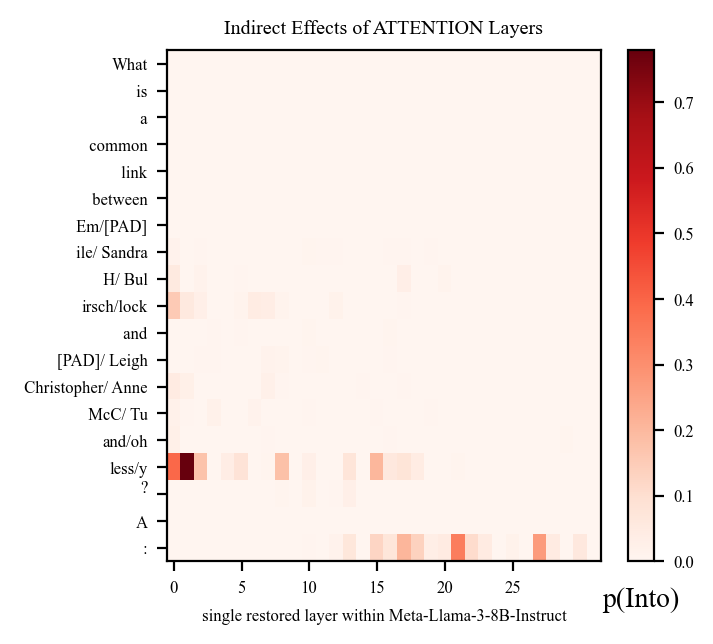

In [34]:
from src.trace import CausalTracingResult
from src.plotting import plot_trace_heatmap

trace_result = CausalTracingResult(
    corrupt_input_toks = [mt.tokenizer.decode(tok) for tok in clean_inputs.input_ids[0][trace_start_idx:]],
    clean_input_toks = [mt.tokenizer.decode(tok) for tok in patch_inputs.input_ids[0][trace_start_idx:]],
    trace_start_idx=0,
    answer = patch_ans,
    low_score = 0.0,
    window = window_size,
    normalized = False,
    # kind="residual",
    # kind="mlp",
    kind="attention",
    indirect_effects=approx_effects,
)

plot_trace_heatmap(
    result = trace_result,
    model_name = mt.name.split("/")[-1],
)

In [35]:
def get_layerwise_head_contributions(layer_idx):
    approx_effects = []
    y_labels = []
    for h_idx in range(mt.model.config.num_attention_heads):
        module_name = mt.attn_module_name_format.format(l_idx) + f".{h_idx}"
        y_labels.append(module_name)
        head_effects = []
        for t_idx in range(query_start, clean_inputs.input_ids.shape[1]):
            head_effects.append(results[(module_name, t_idx)])
        approx_effects.append(head_effects)
    
    approx_effects = torch.Tensor(approx_effects)
    return approx_effects, y_labels

In [36]:
import matplotlib.pyplot as plt

def plot_head_indirect_effect(
        layer_idx, x_labels, y_labels, approx_effects, save_pdf = None
):
    abs_max = approx_effects.abs().max().item()
    with plt.rc_context(
        rc={
            "font.family": "Times New Roman",
            "font.size": 3,
        }
    ):
        plt.rcParams["figure.dpi"] = 300
        img = plt.imshow(
            approx_effects,
            cmap="RdBu",
            interpolation="nearest",
            vmin= -abs_max,
            vmax= abs_max,
        )
        plt.yticks(range(len(y_labels)), y_labels)
        plt.xticks(range(len(x_labels)), x_labels, rotation=90)
        plt.colorbar(img, orientation="vertical", aspect=50)
        plt.title(f"ATTN Layer {layer_idx+1} IE")

        if save_pdf is not None:
            plt.savefig(save_pdf, format="pdf", bbox_inches="tight")

        plt.show()

2024-08-14 12:43:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f29606f8cd0>


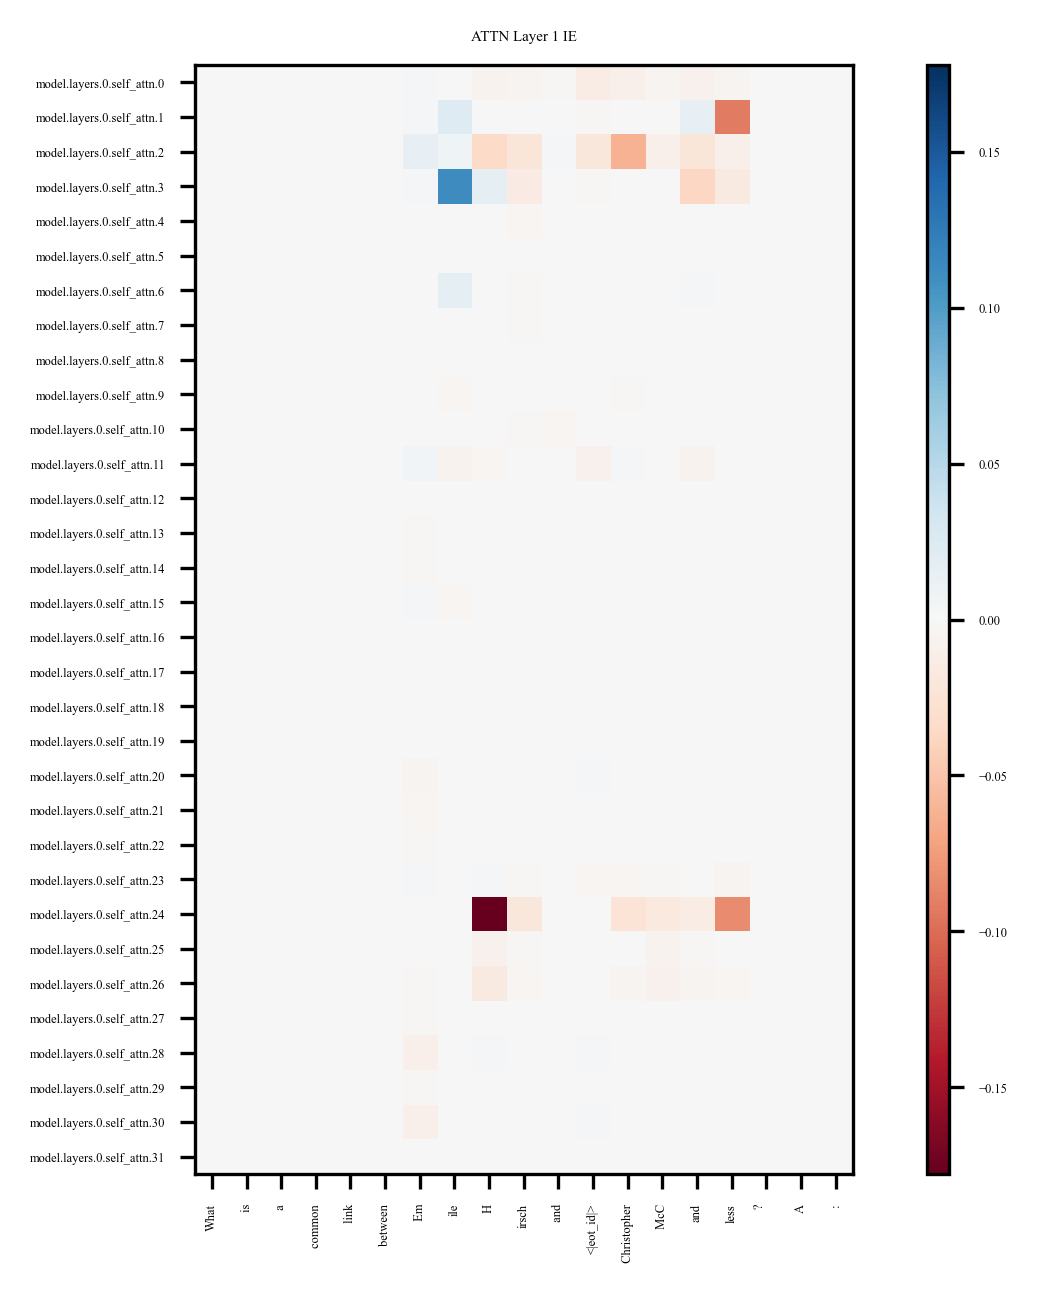

2024-08-14 12:43:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f29604fa590>


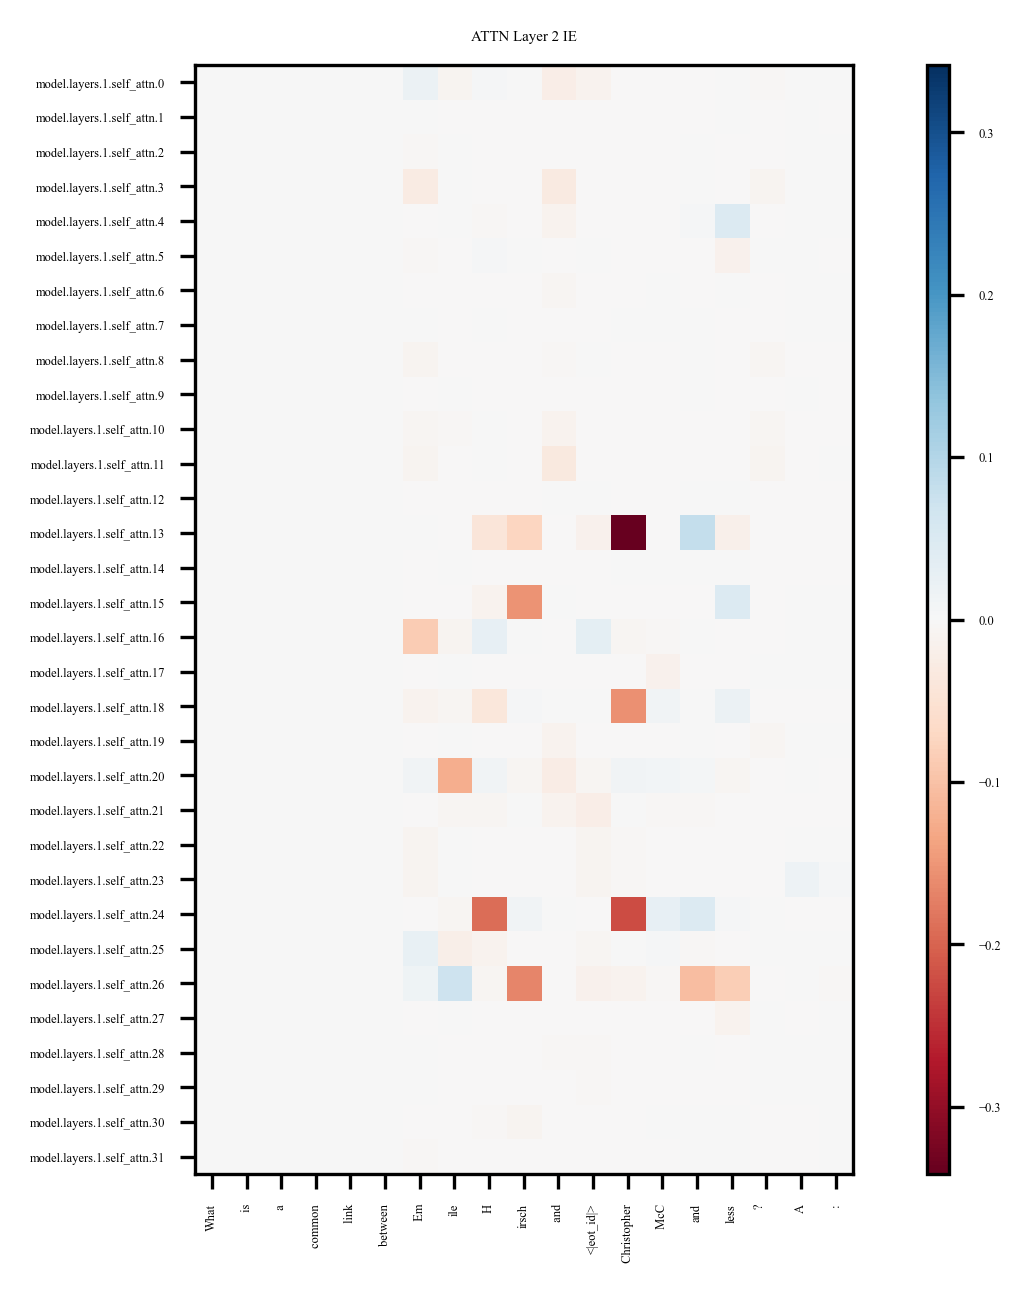

2024-08-14 12:43:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f296039f590>


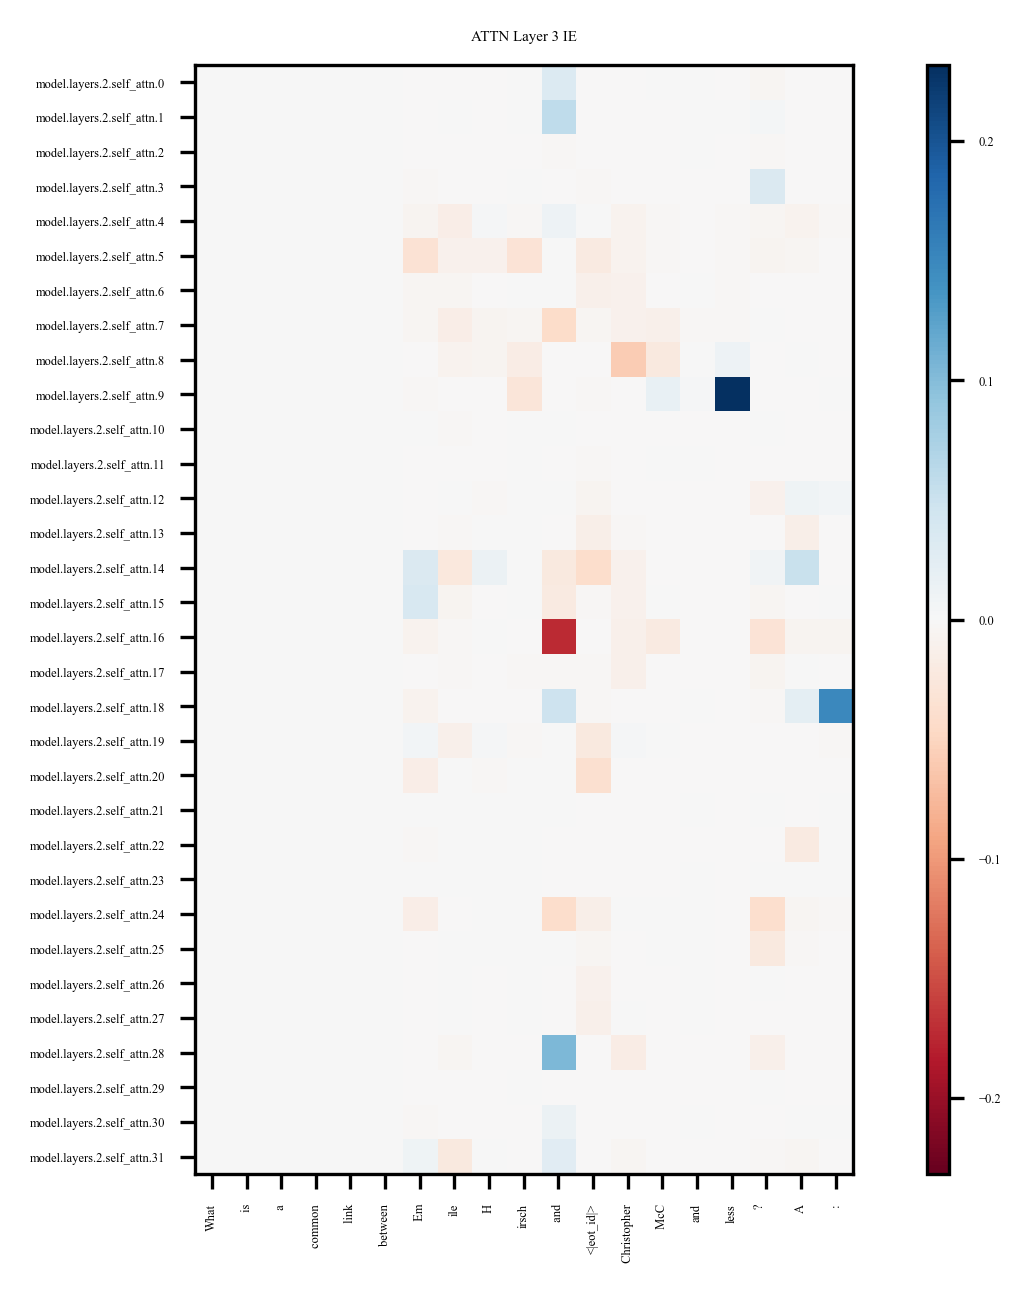

2024-08-14 12:43:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f29602ae1d0>


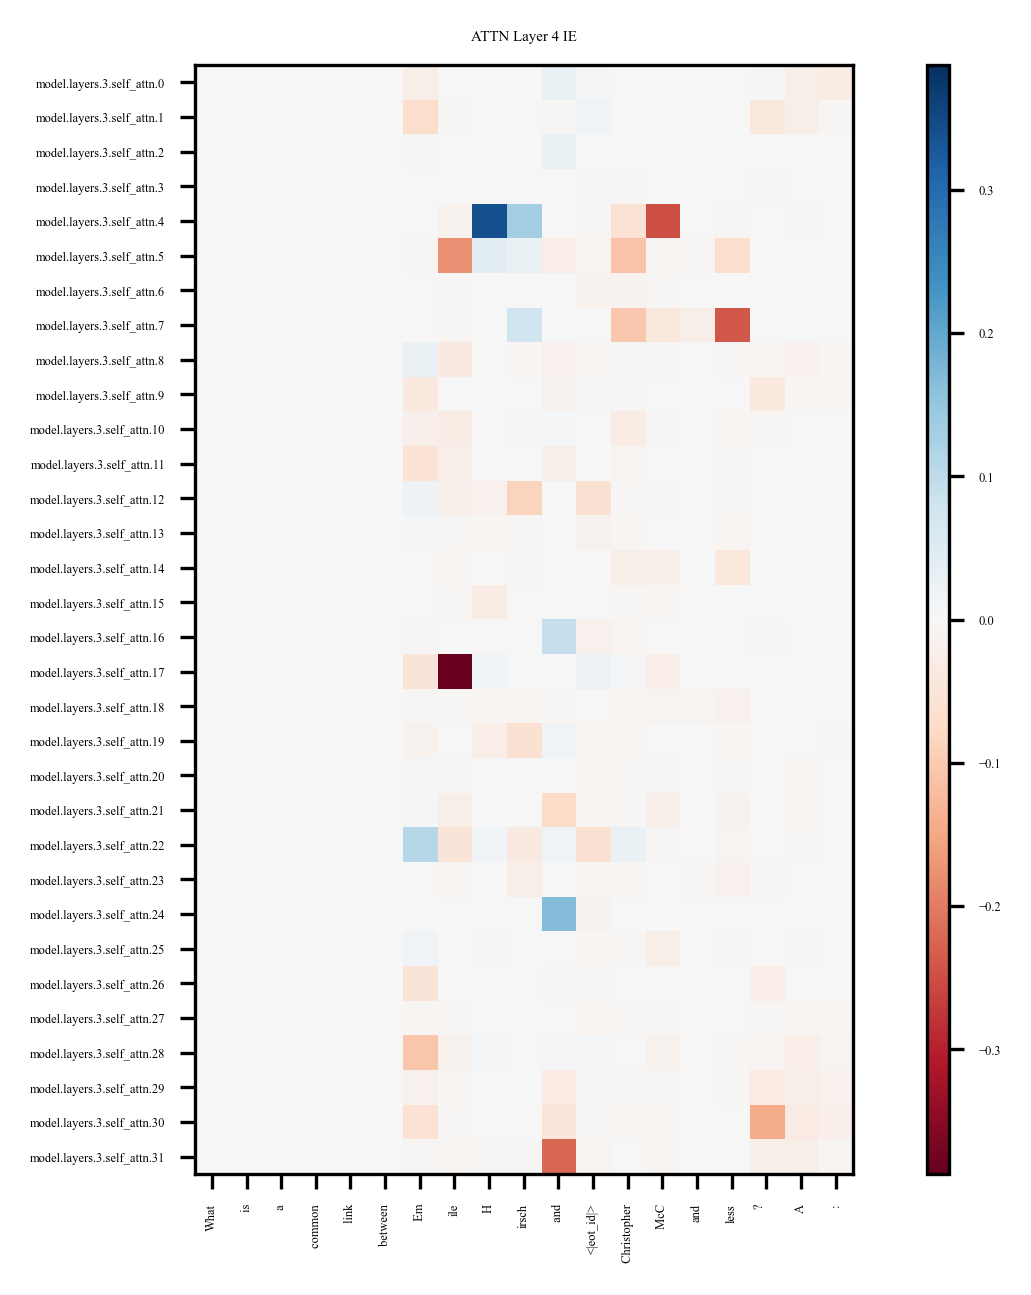

2024-08-14 12:43:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f2960065750>


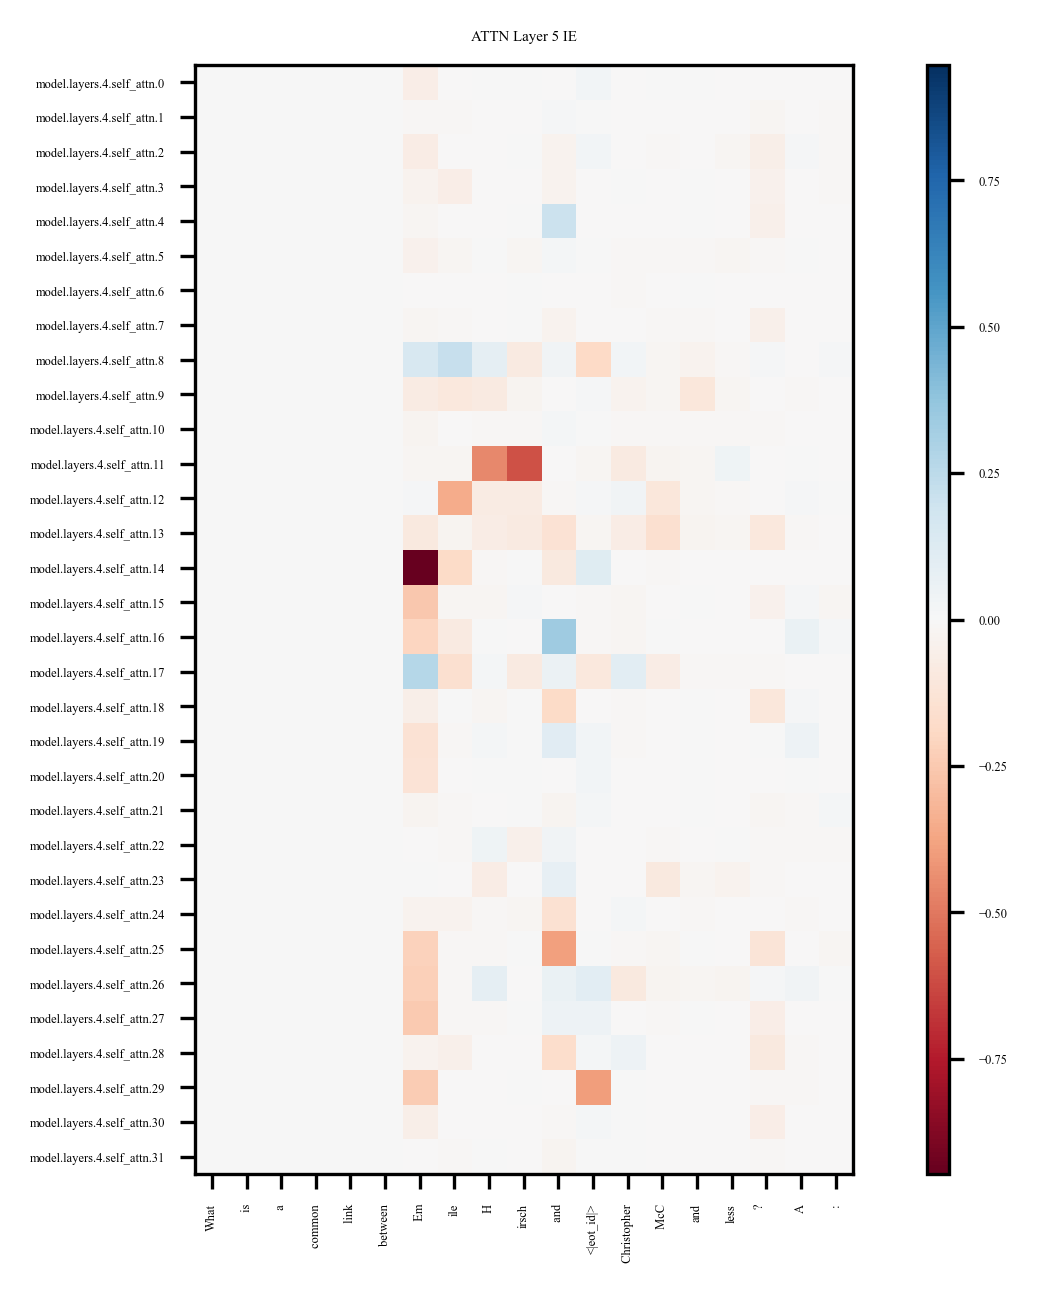

2024-08-14 12:43:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f2a39ba92d0>


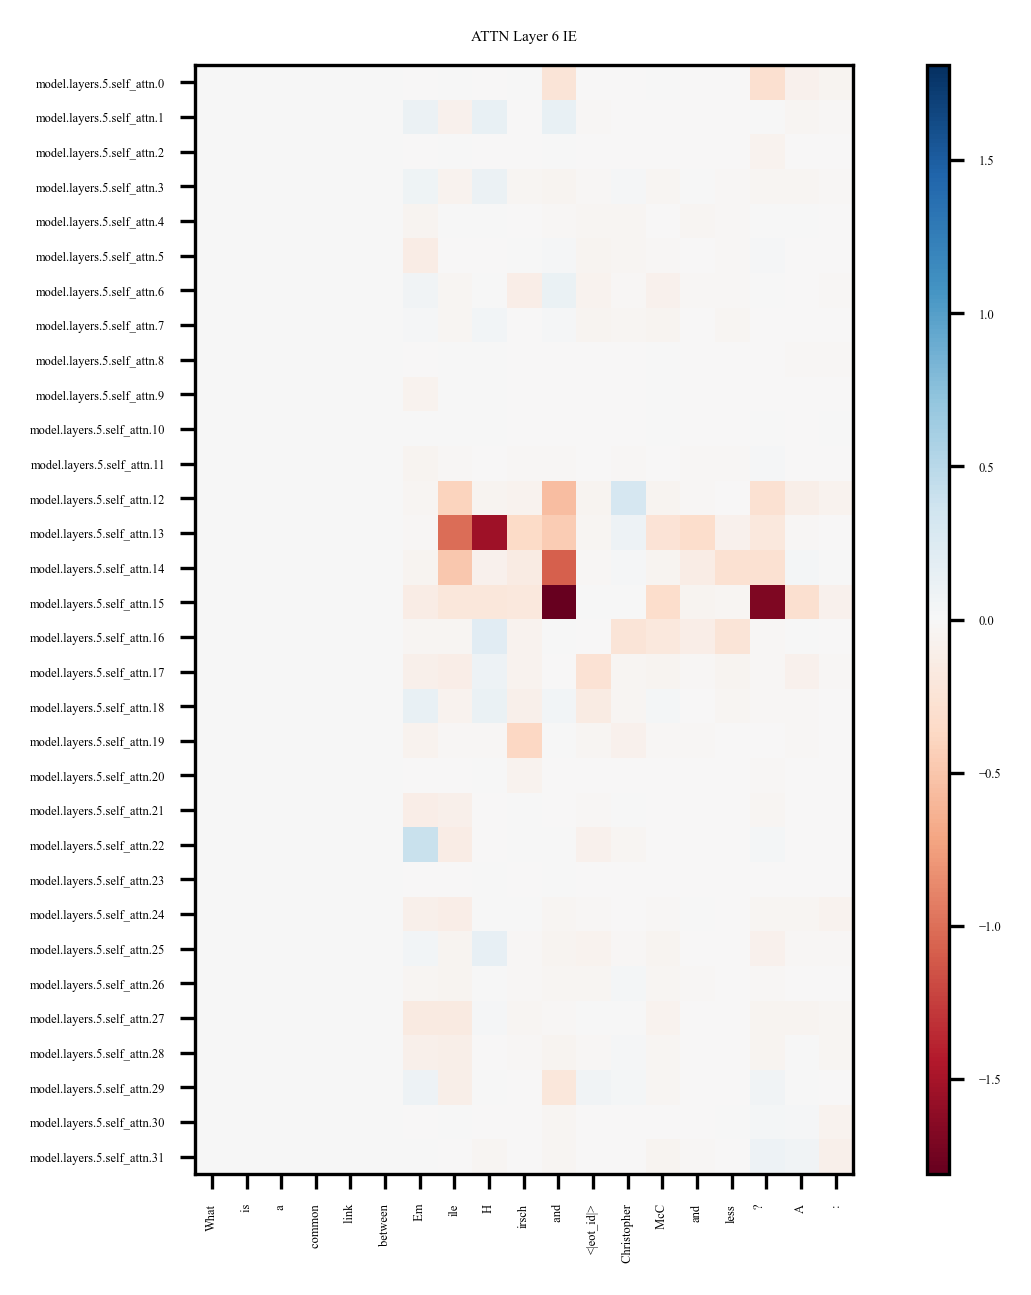

2024-08-14 12:43:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294be3a410>


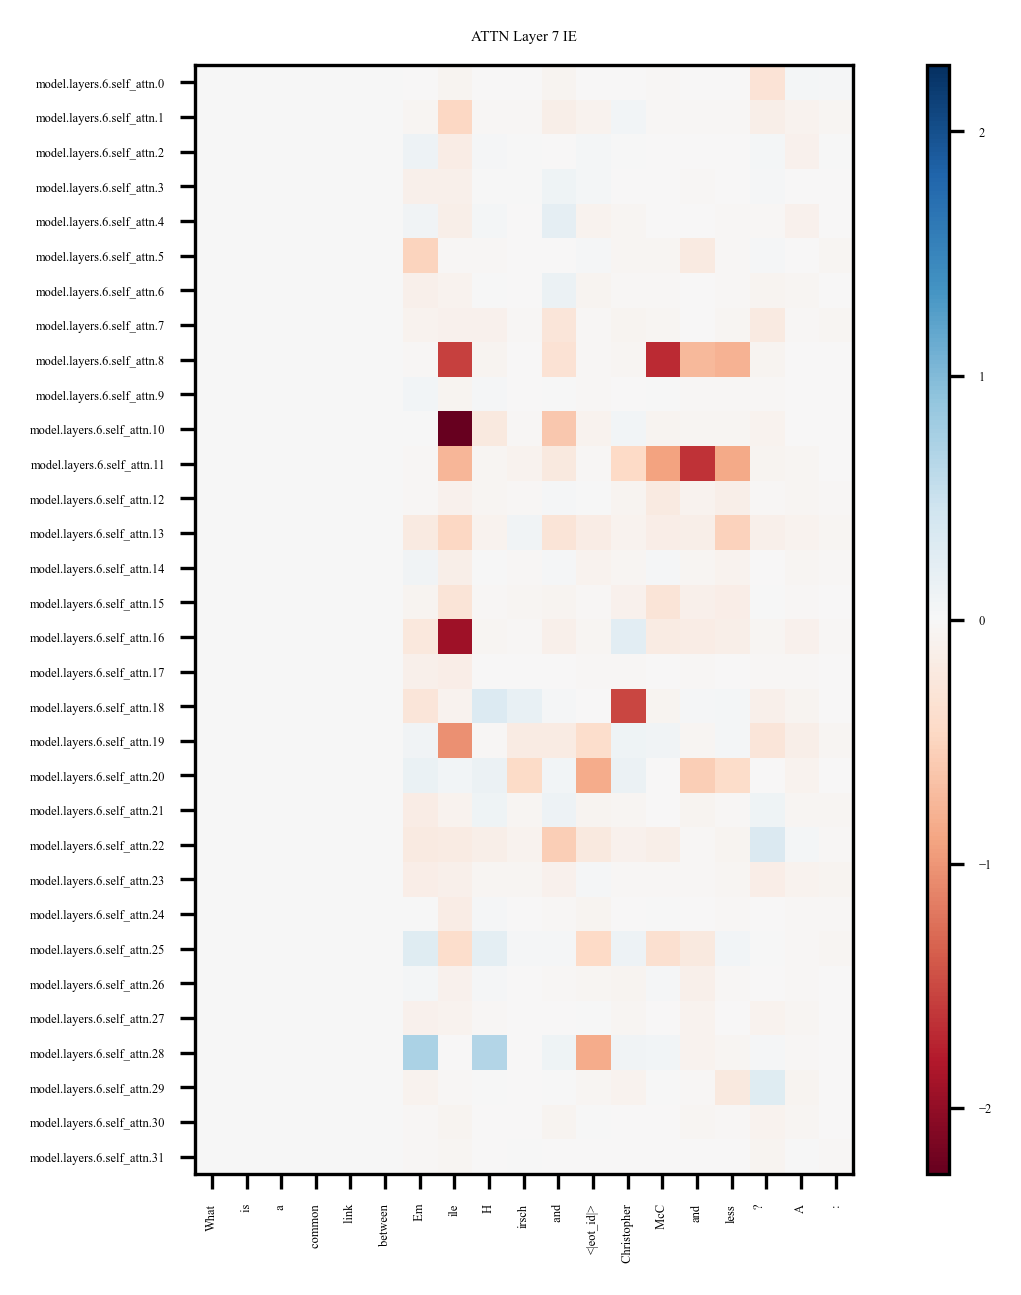

2024-08-14 12:43:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f2a39b39cd0>


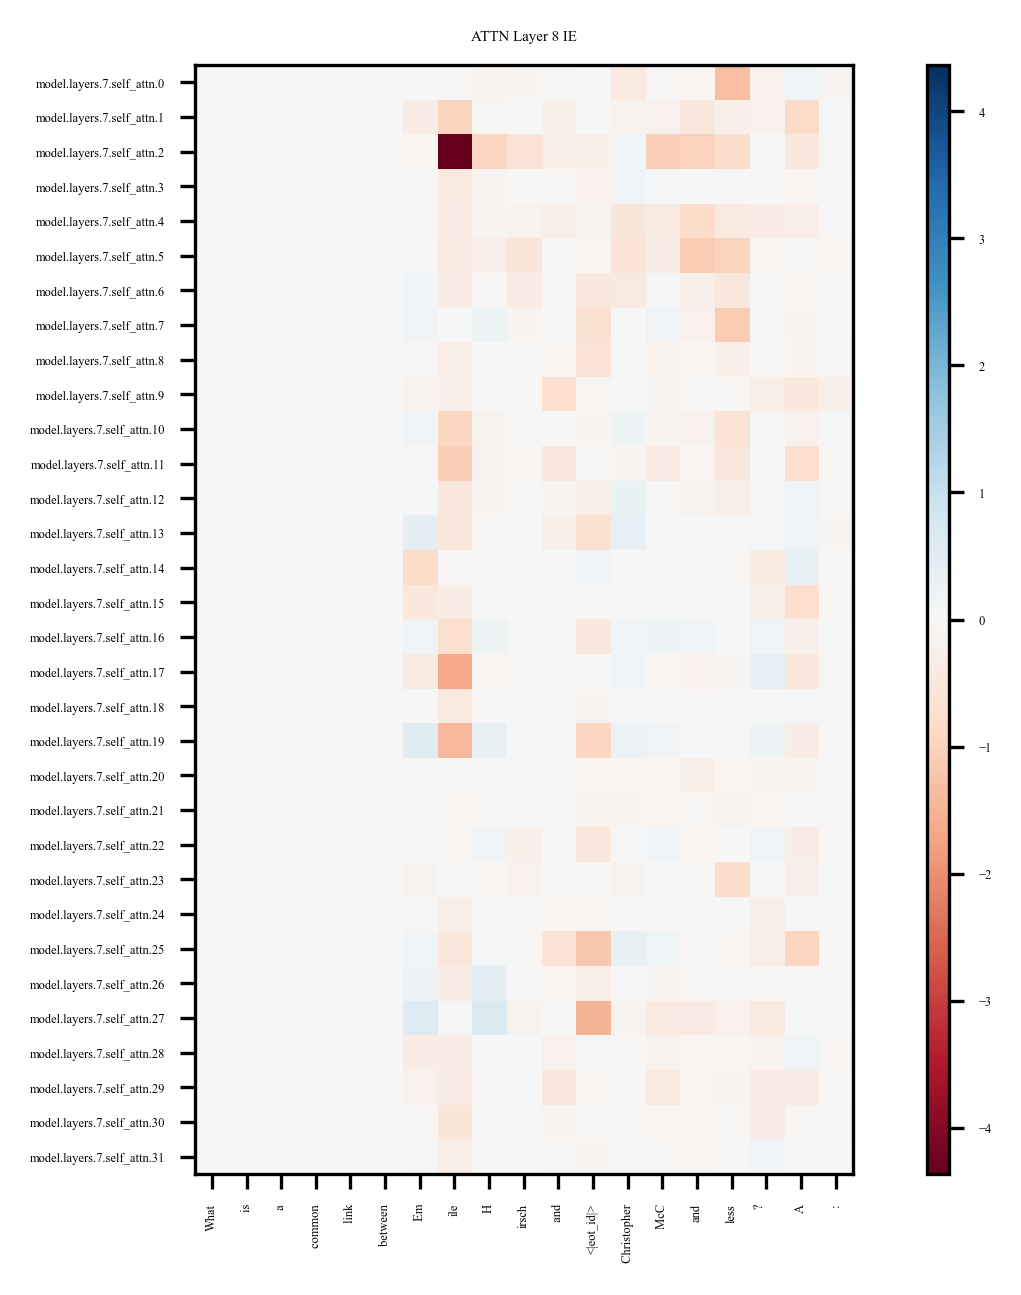

2024-08-14 12:43:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294bc8e890>


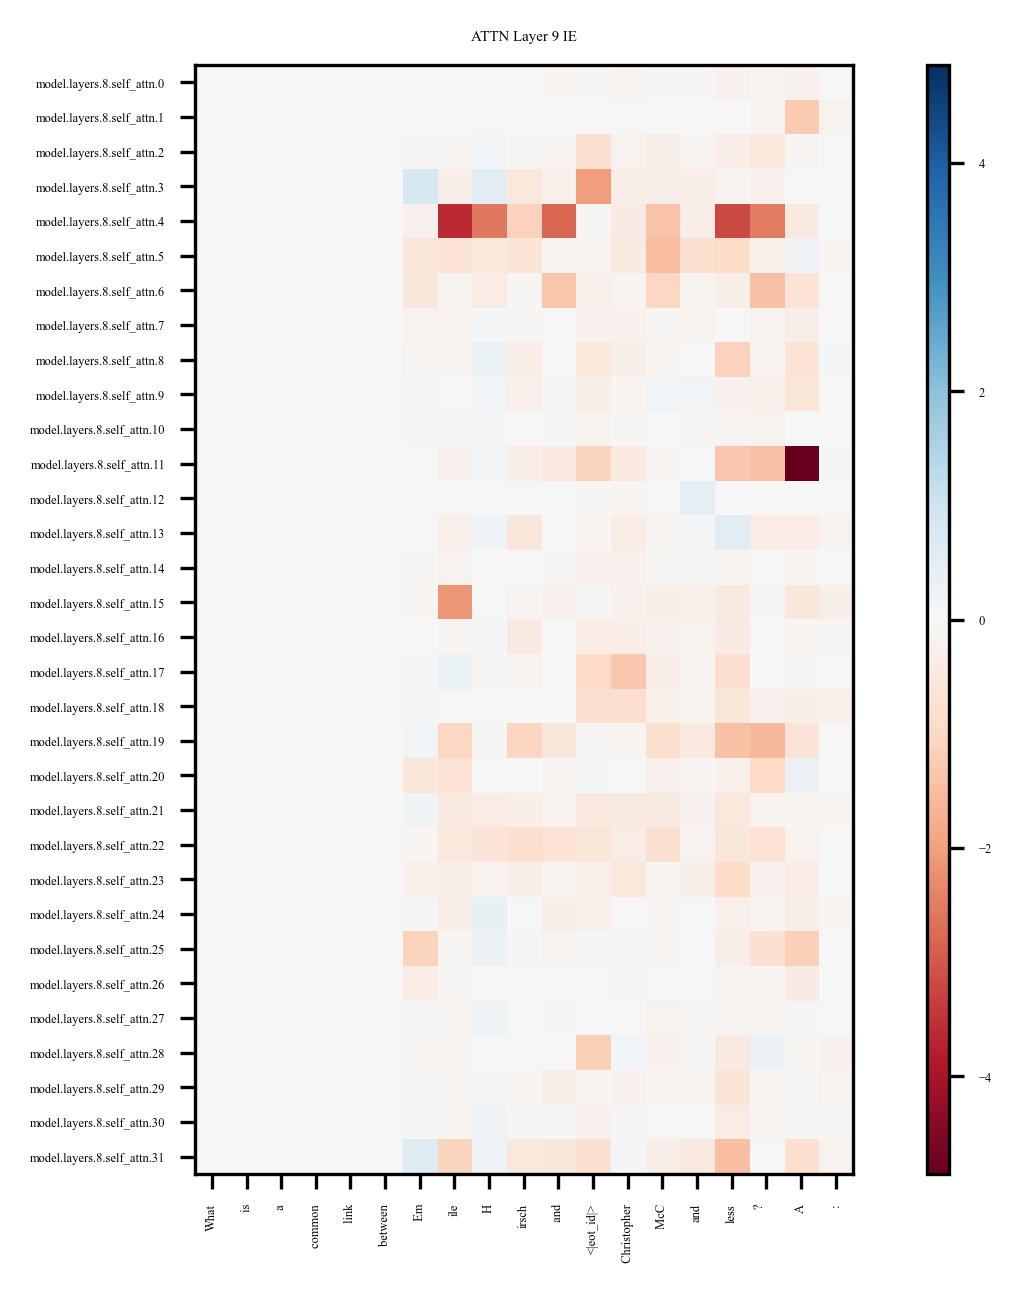

2024-08-14 12:43:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294ba42dd0>


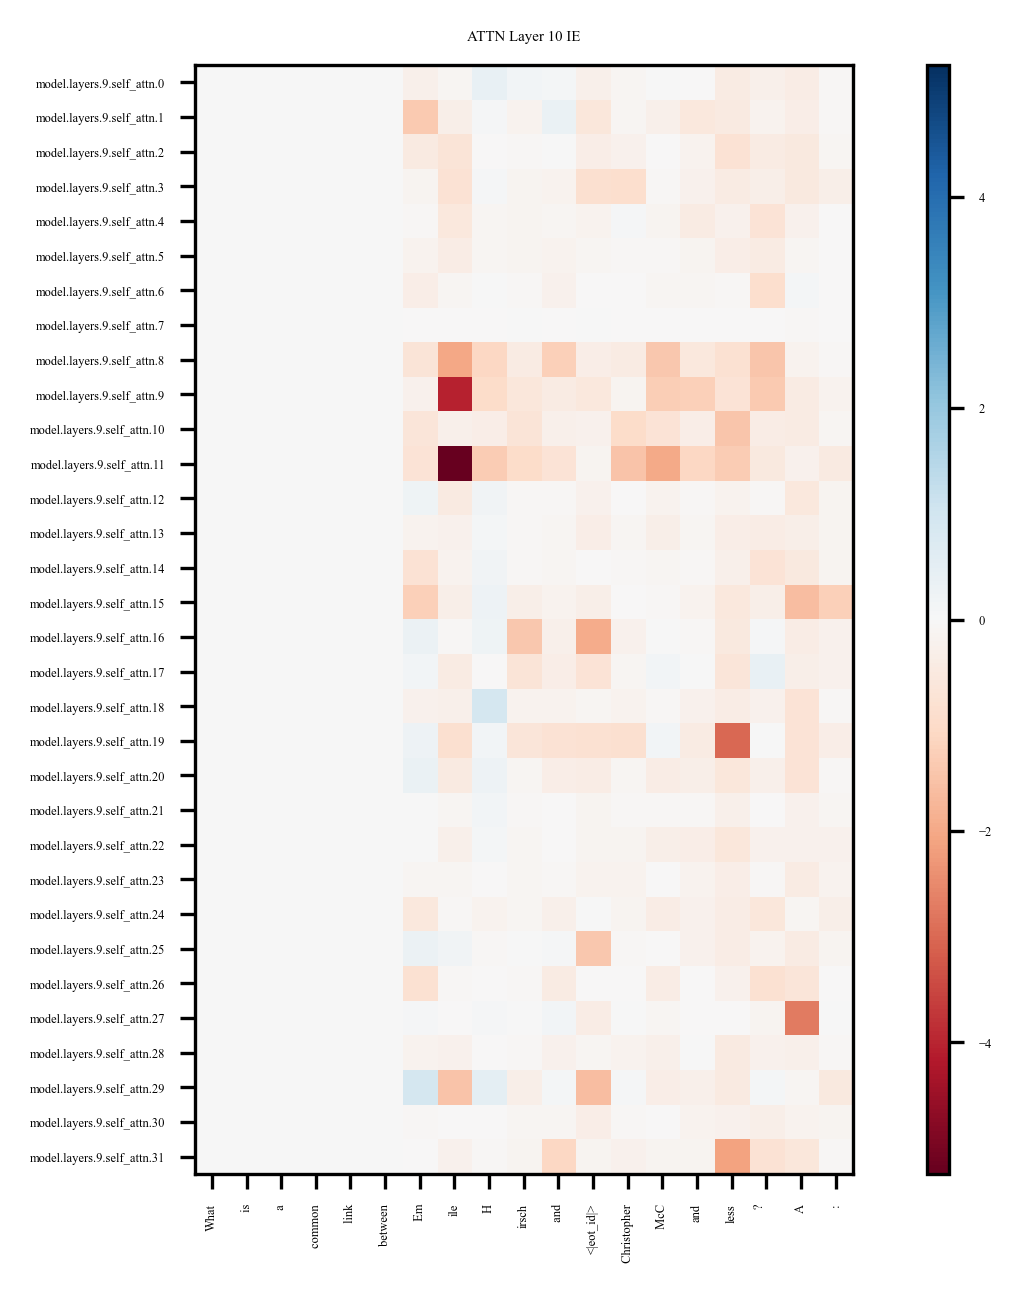

2024-08-14 12:43:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294ba403d0>


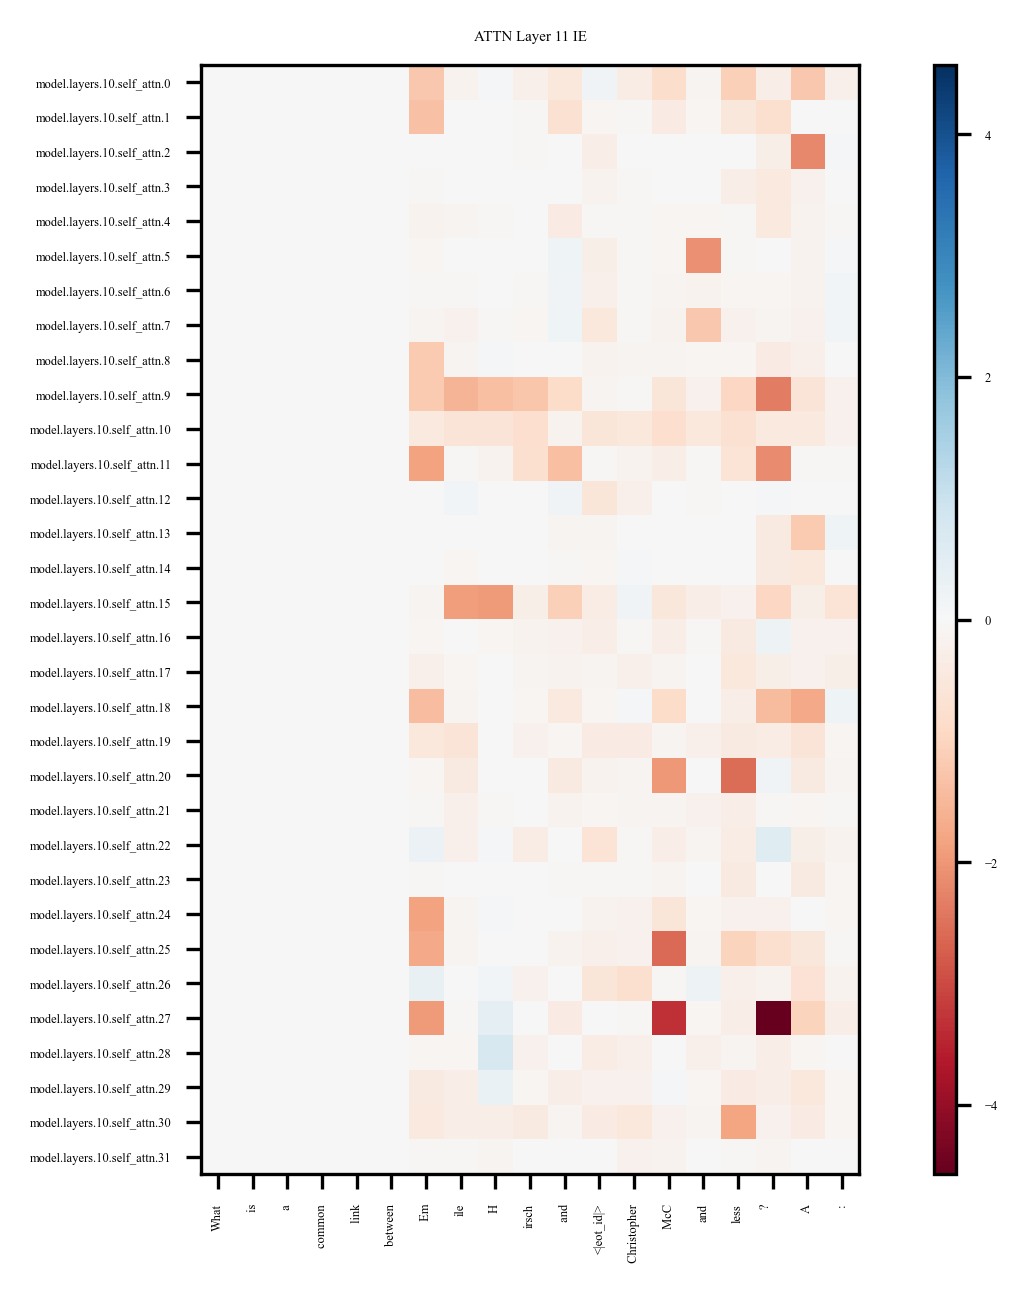

2024-08-14 12:44:00 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b82c2d0>


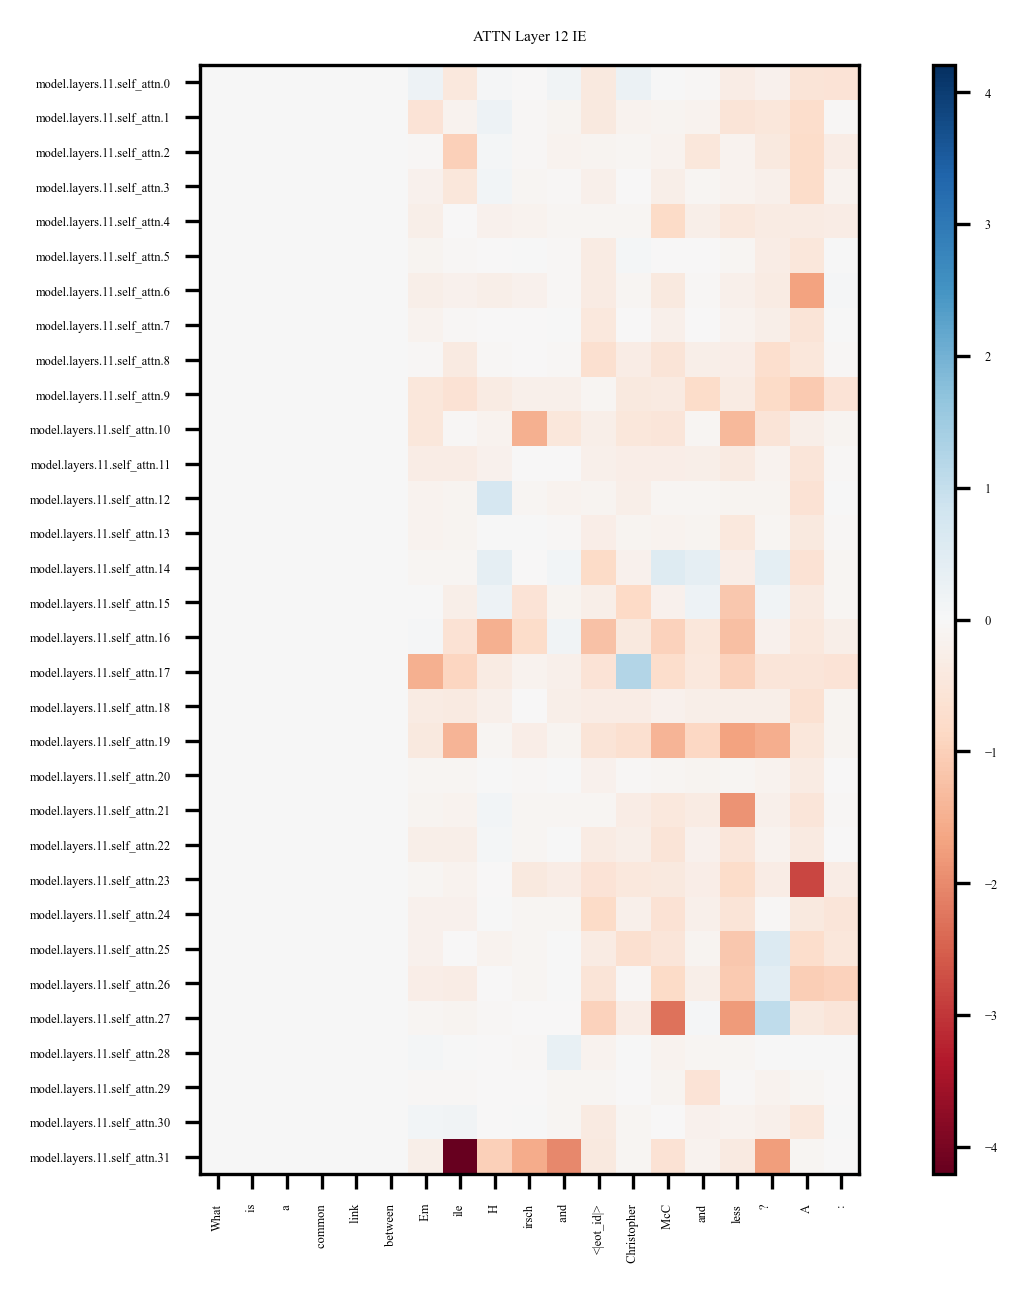

2024-08-14 12:44:00 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b74f9d0>


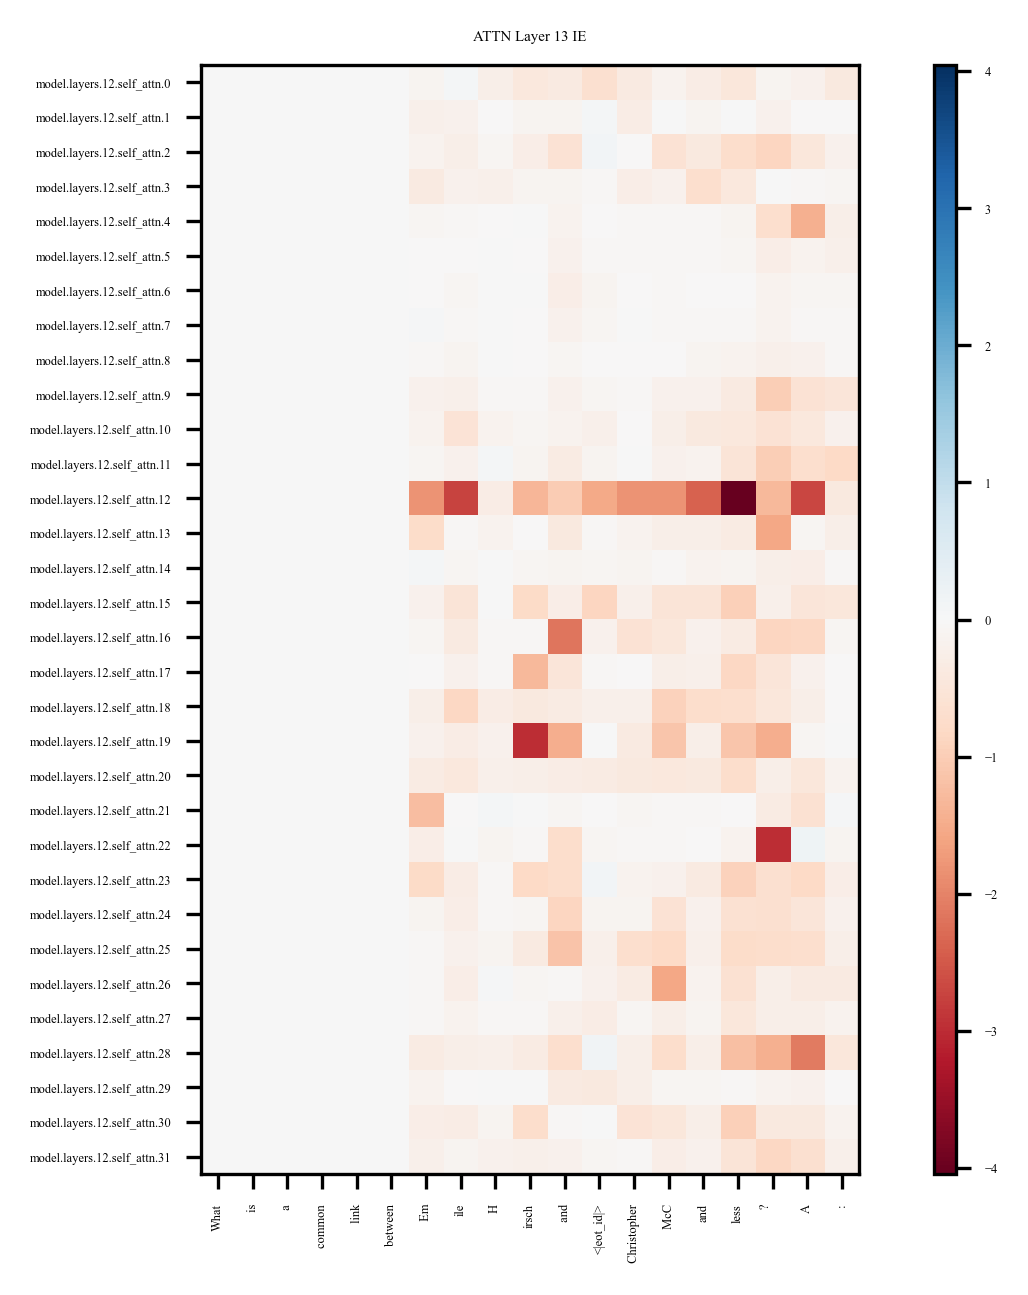

2024-08-14 12:44:00 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b9f73d0>


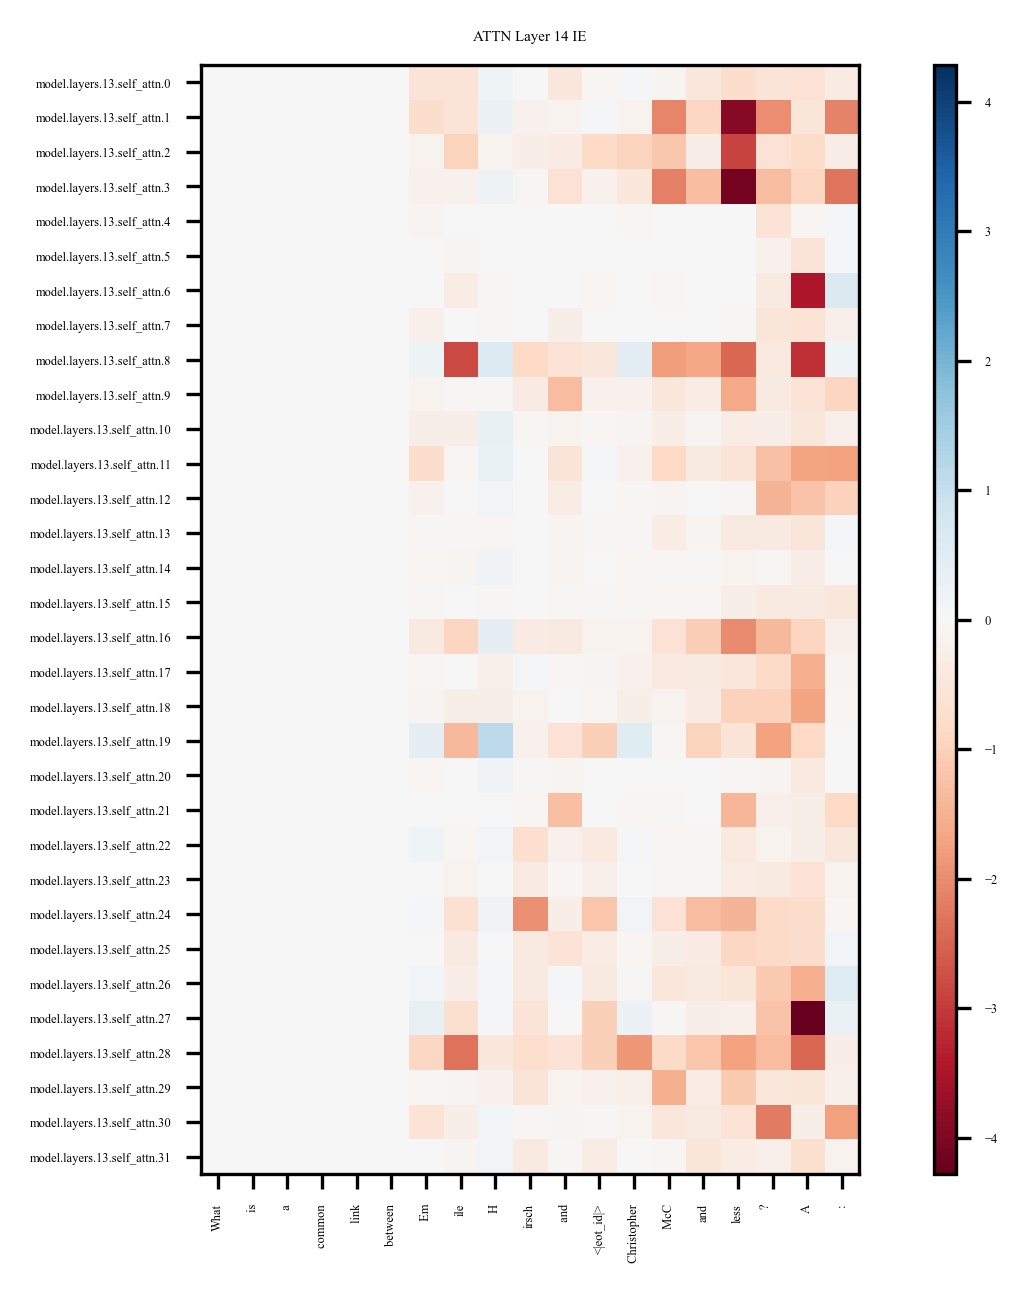

2024-08-14 12:44:00 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b5f6950>


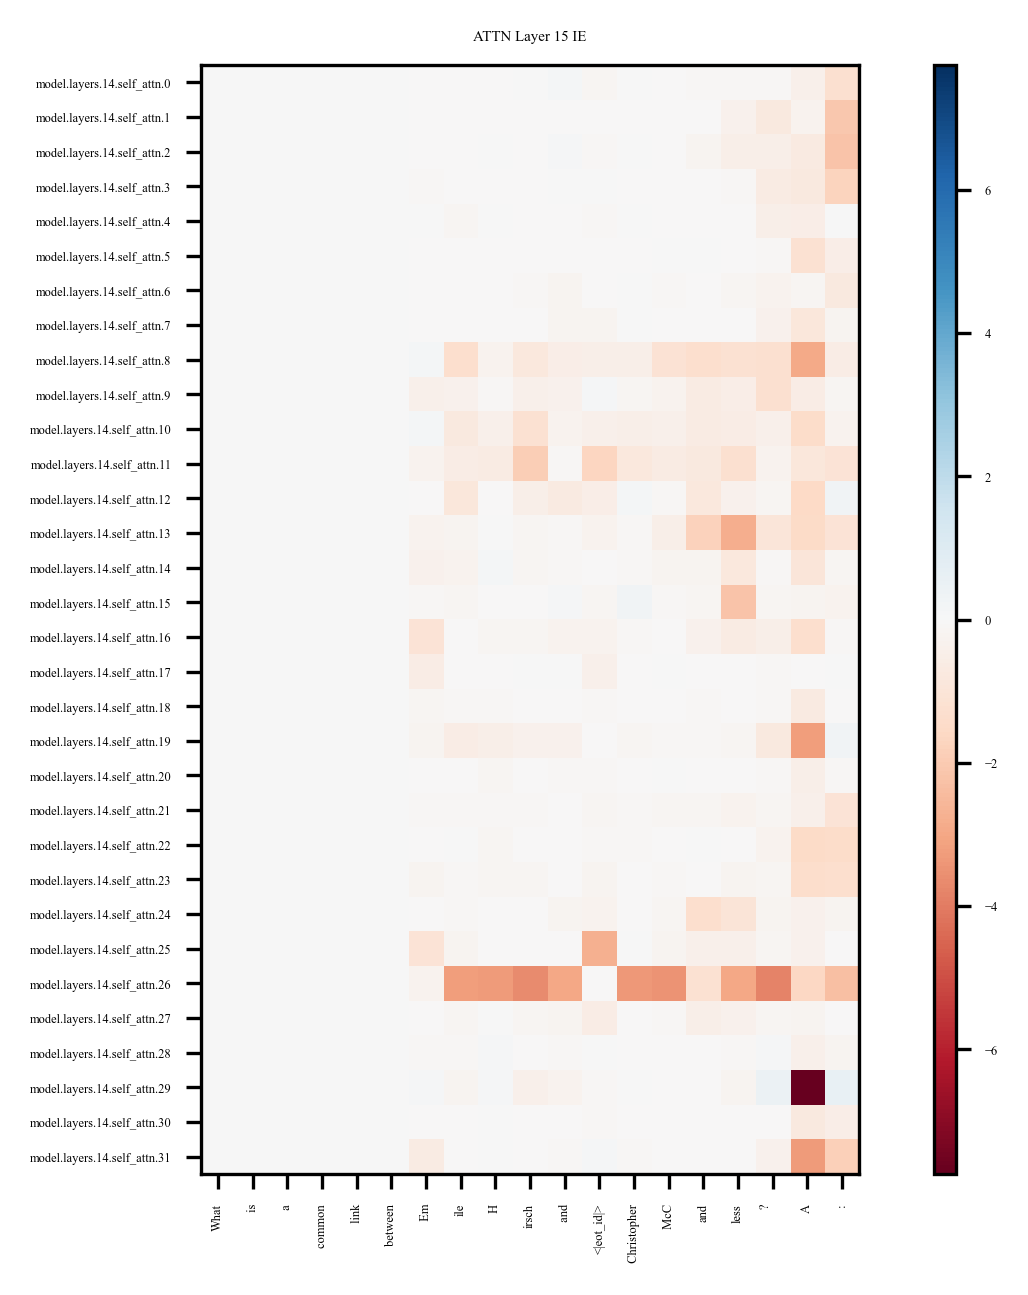

2024-08-14 12:44:01 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b370dd0>


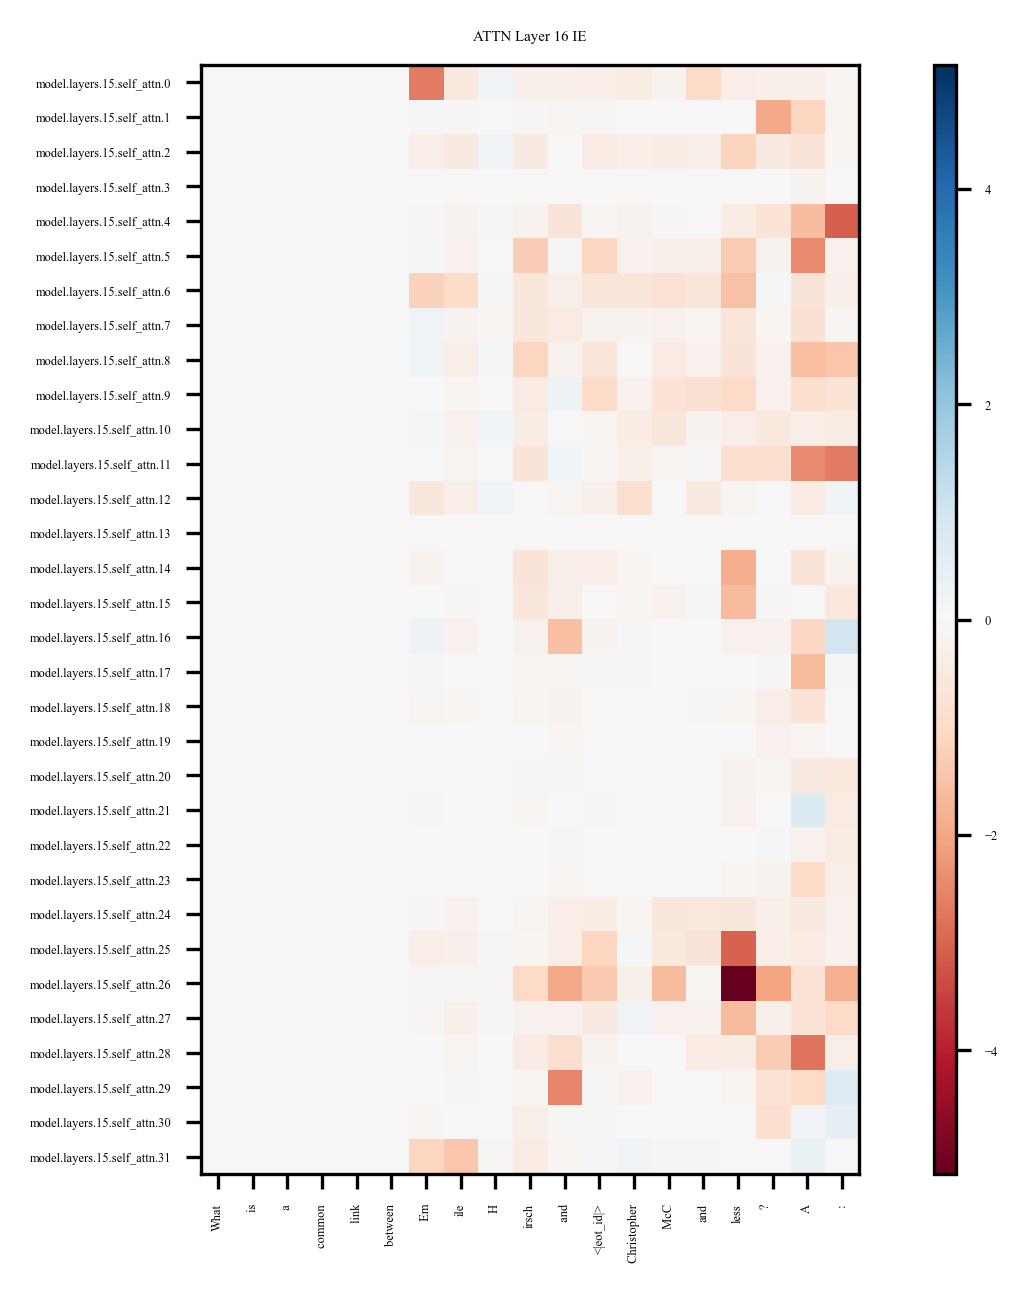

2024-08-14 12:44:01 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b26d710>


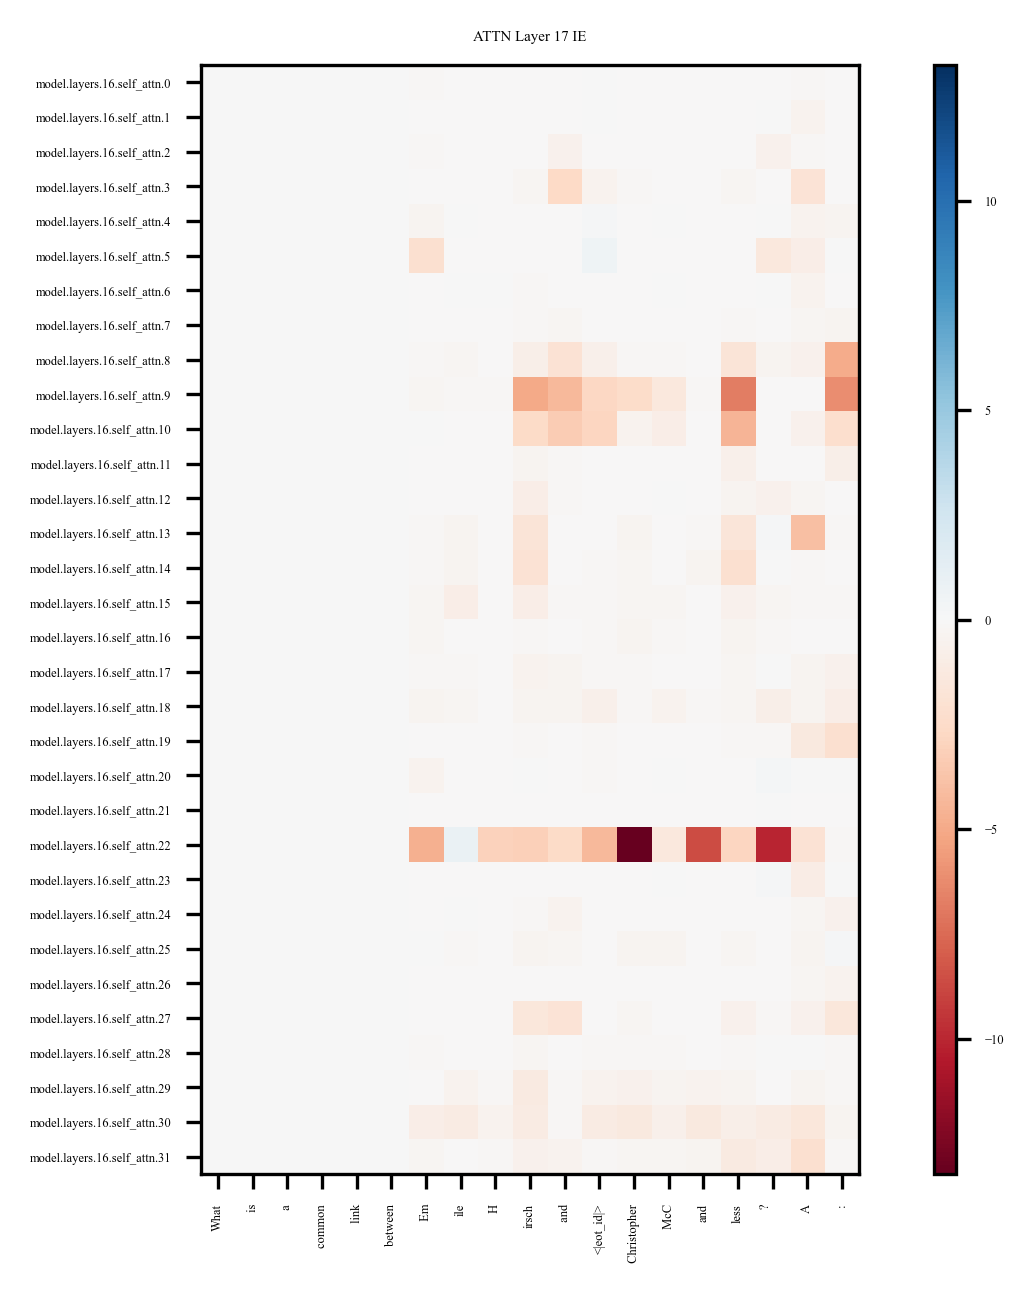

2024-08-14 12:44:01 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b140990>


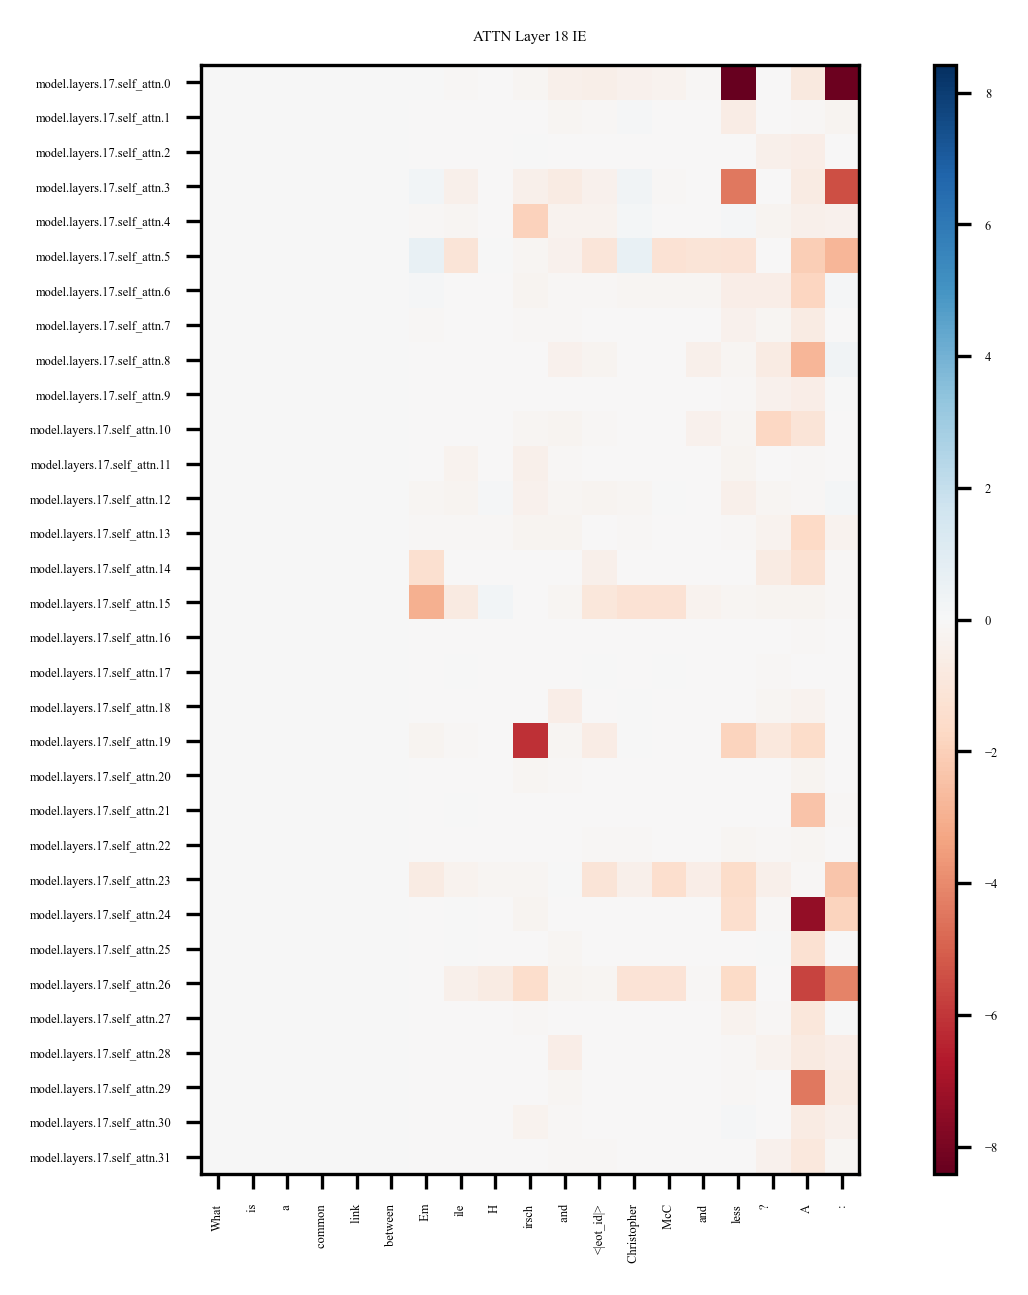

2024-08-14 12:44:01 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294b066b90>


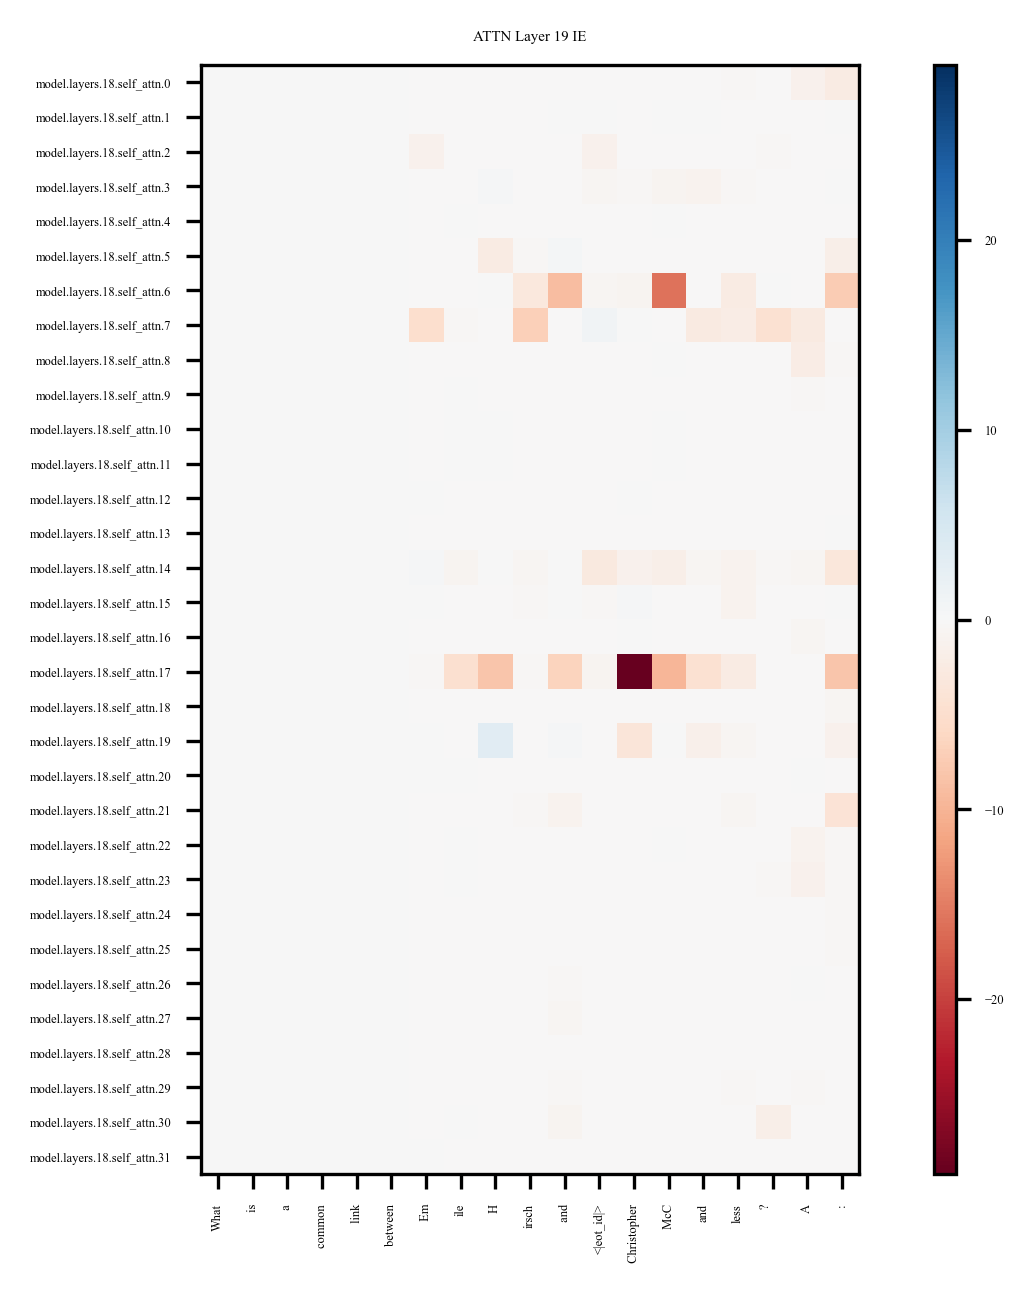

2024-08-14 12:44:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294afd6010>


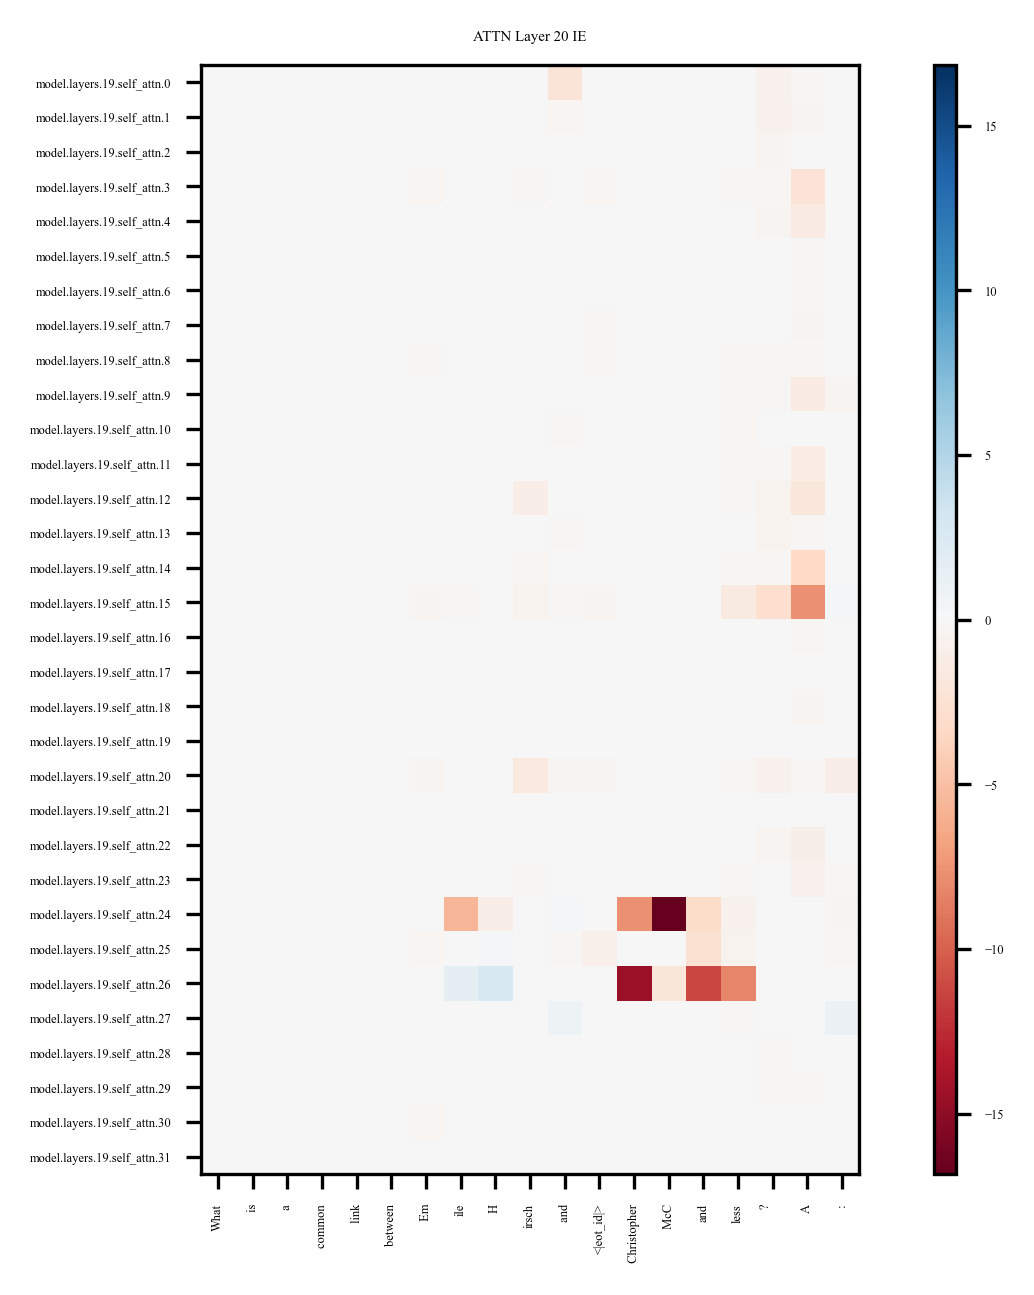

2024-08-14 12:44:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294ae5f6d0>


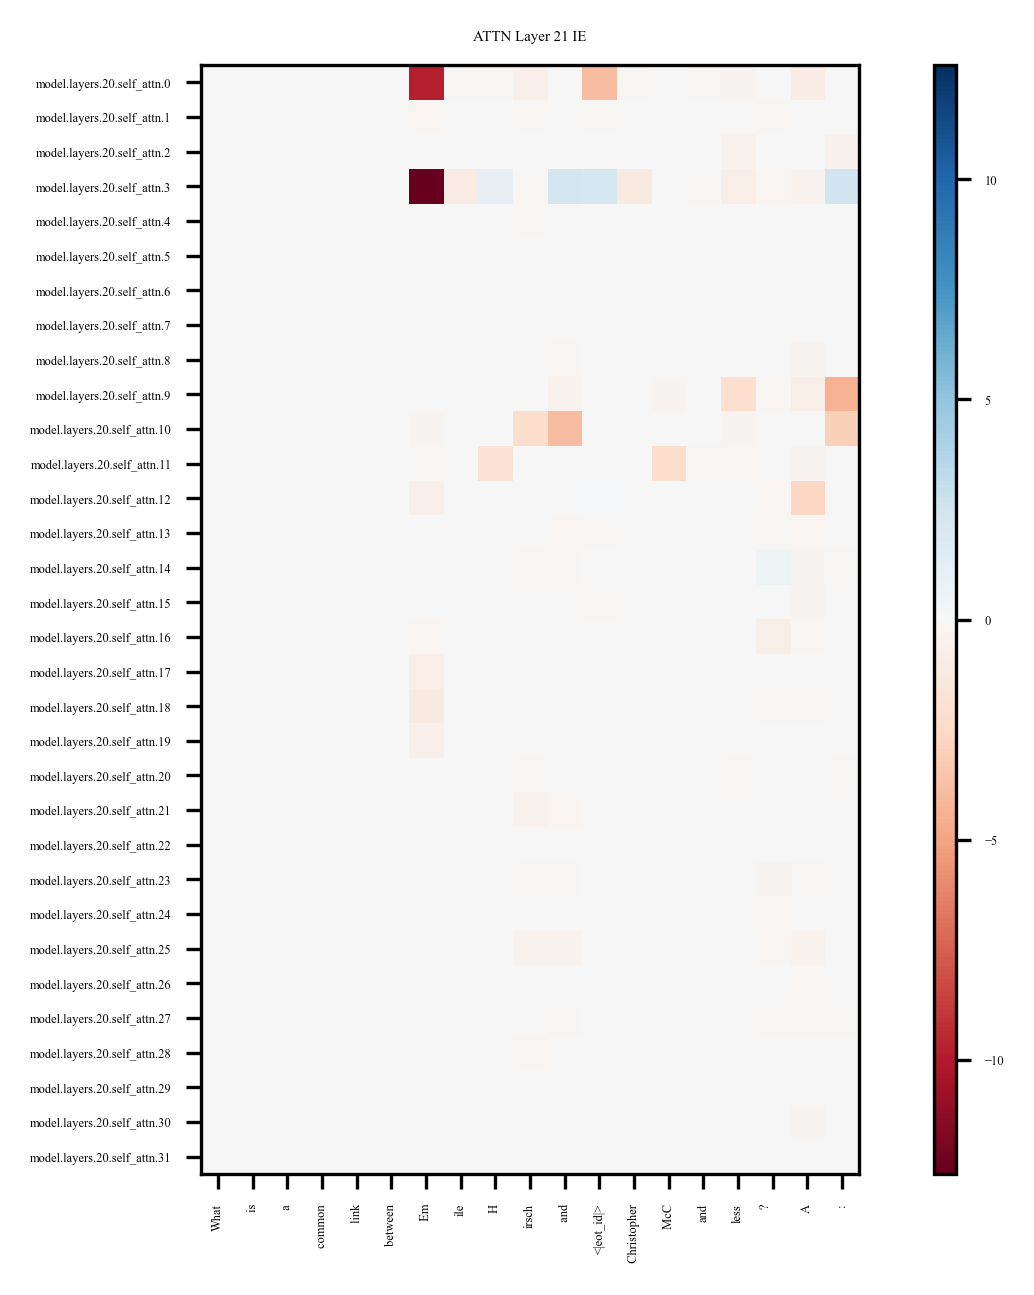

2024-08-14 12:44:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294ad3f810>


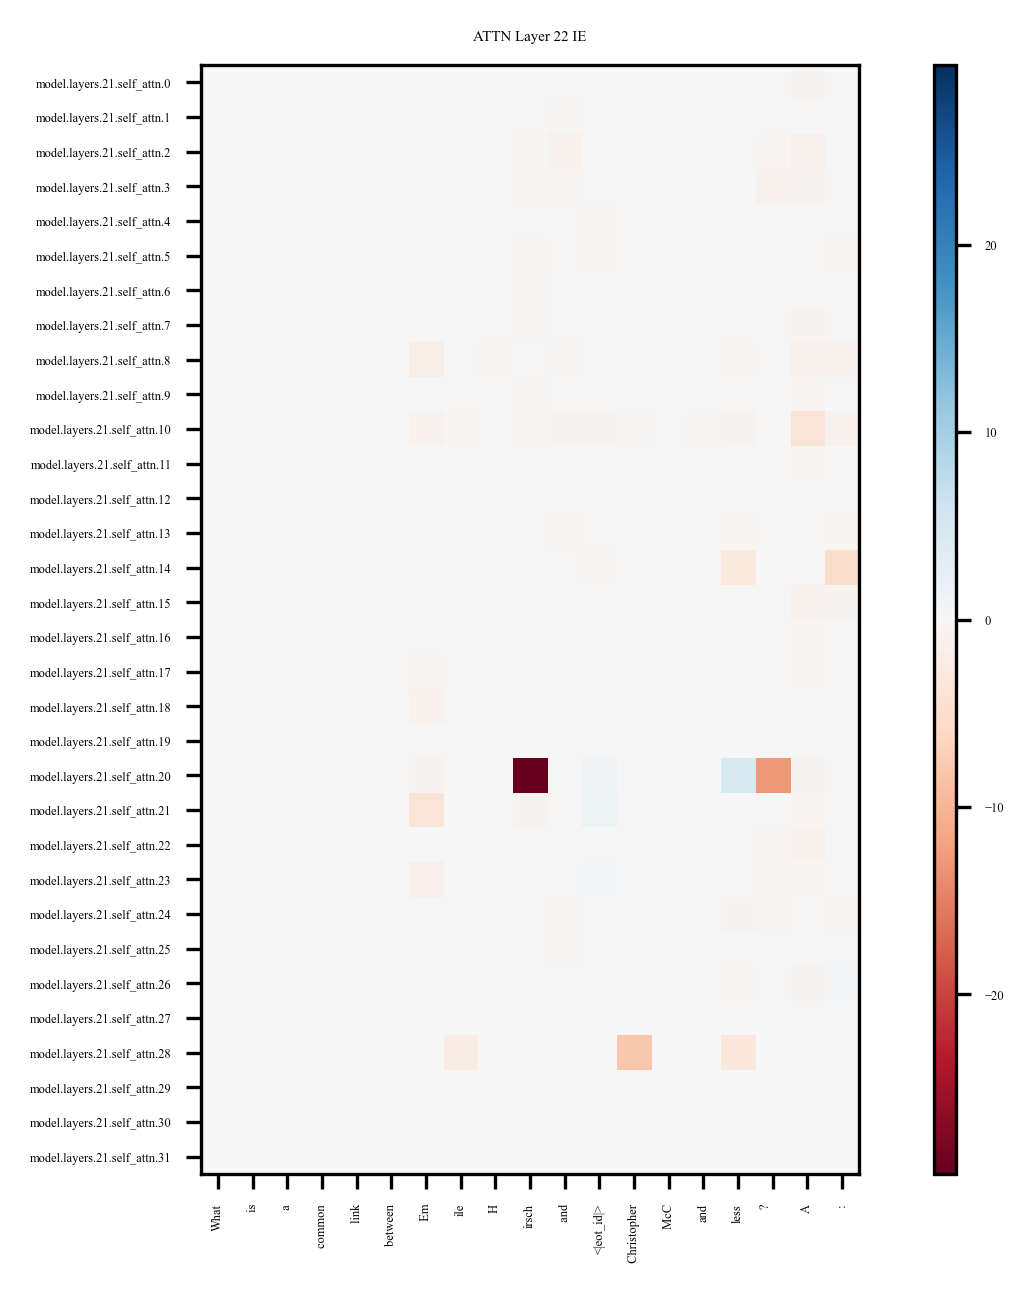

2024-08-14 12:44:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294ab23d10>


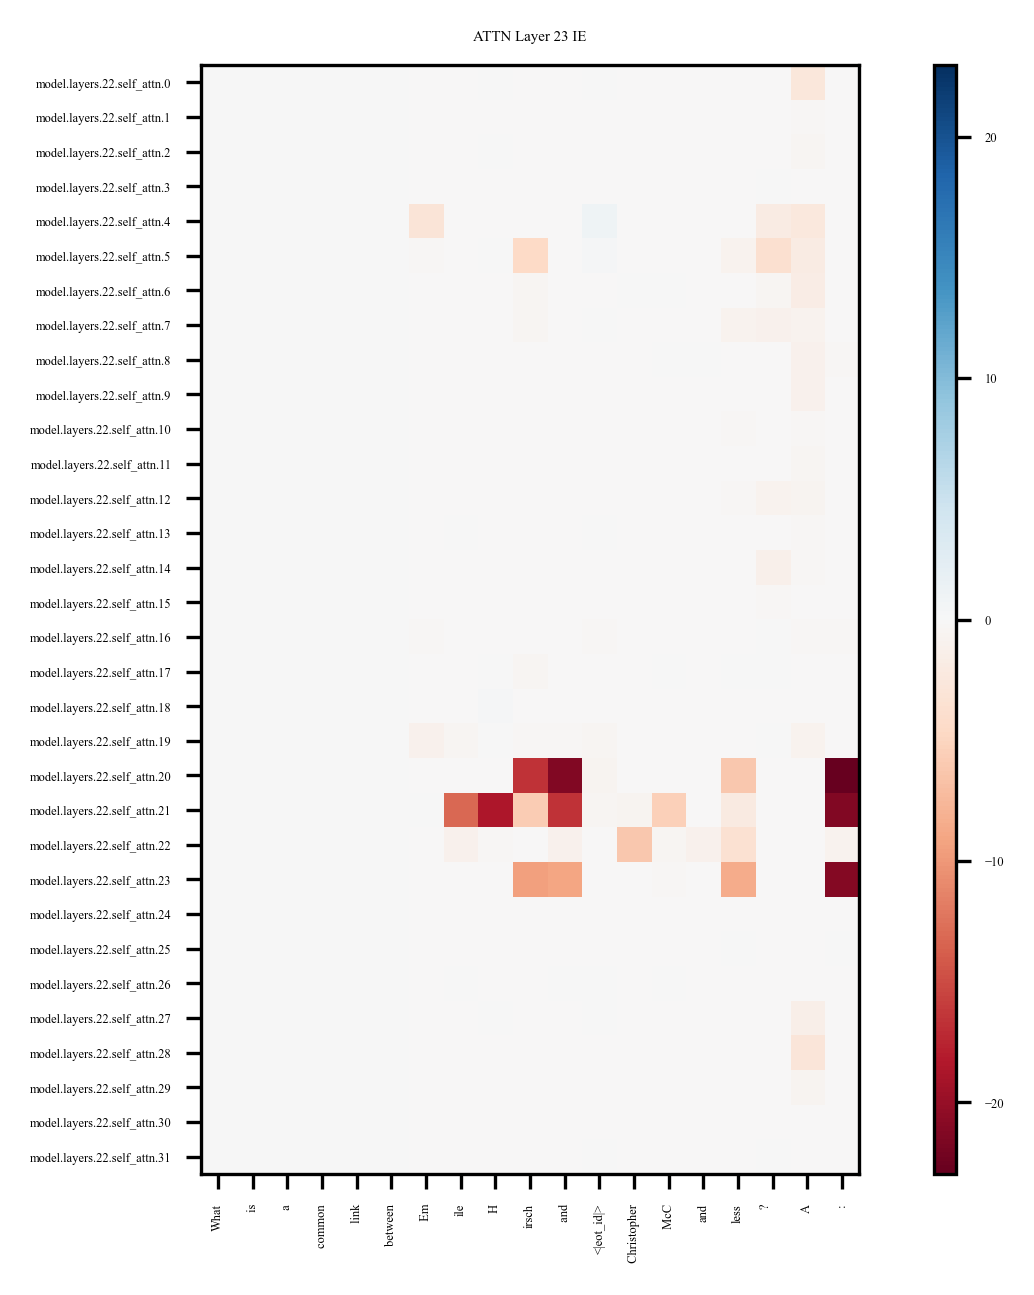

2024-08-14 12:44:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294aa46e50>


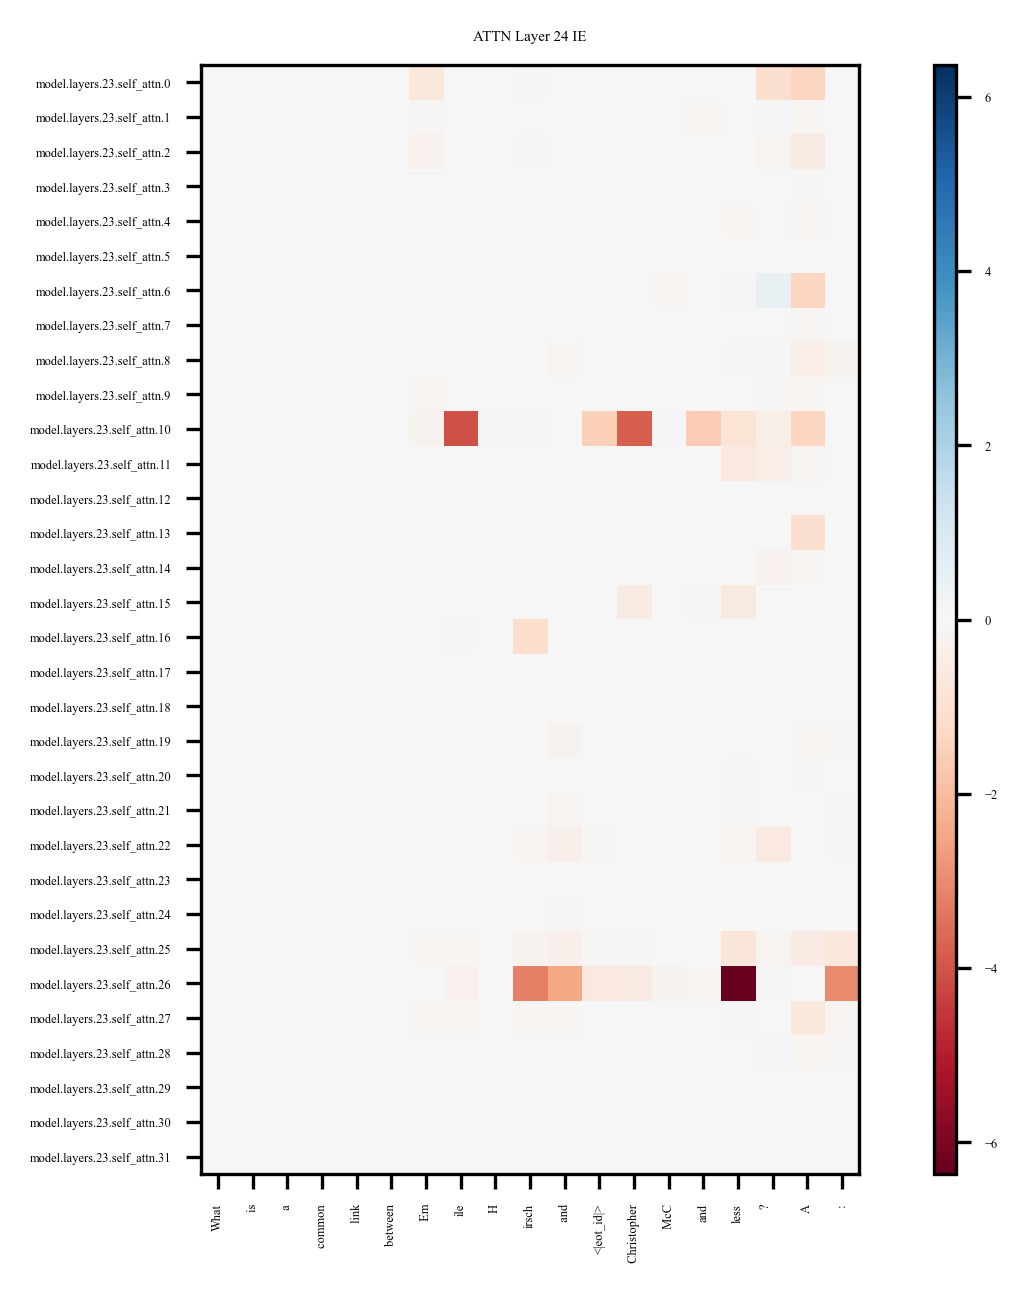

2024-08-14 12:44:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294a939cd0>


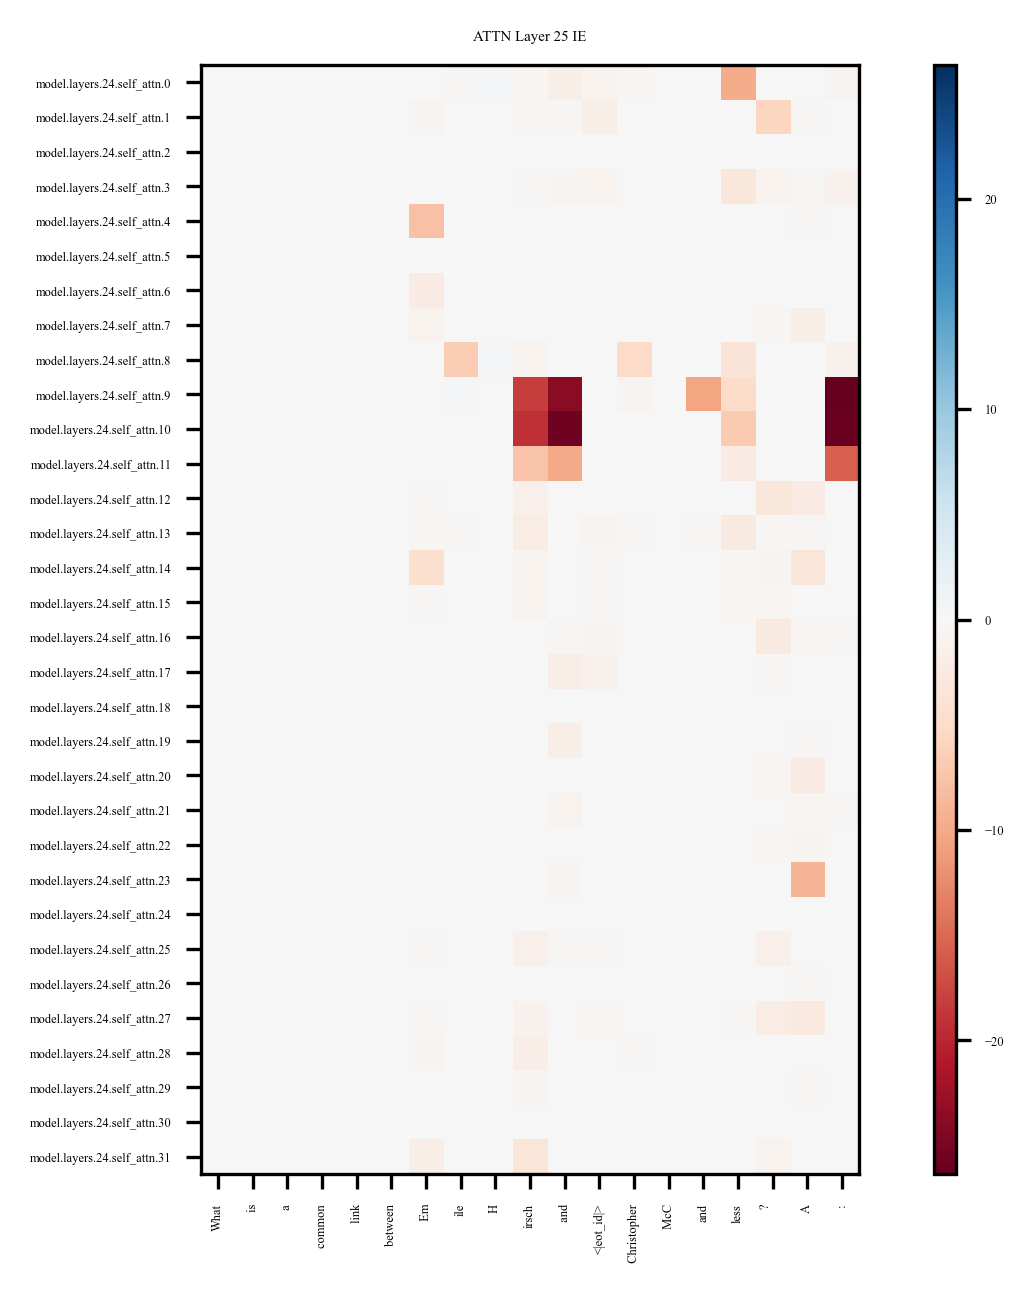

2024-08-14 12:44:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294a8b7650>


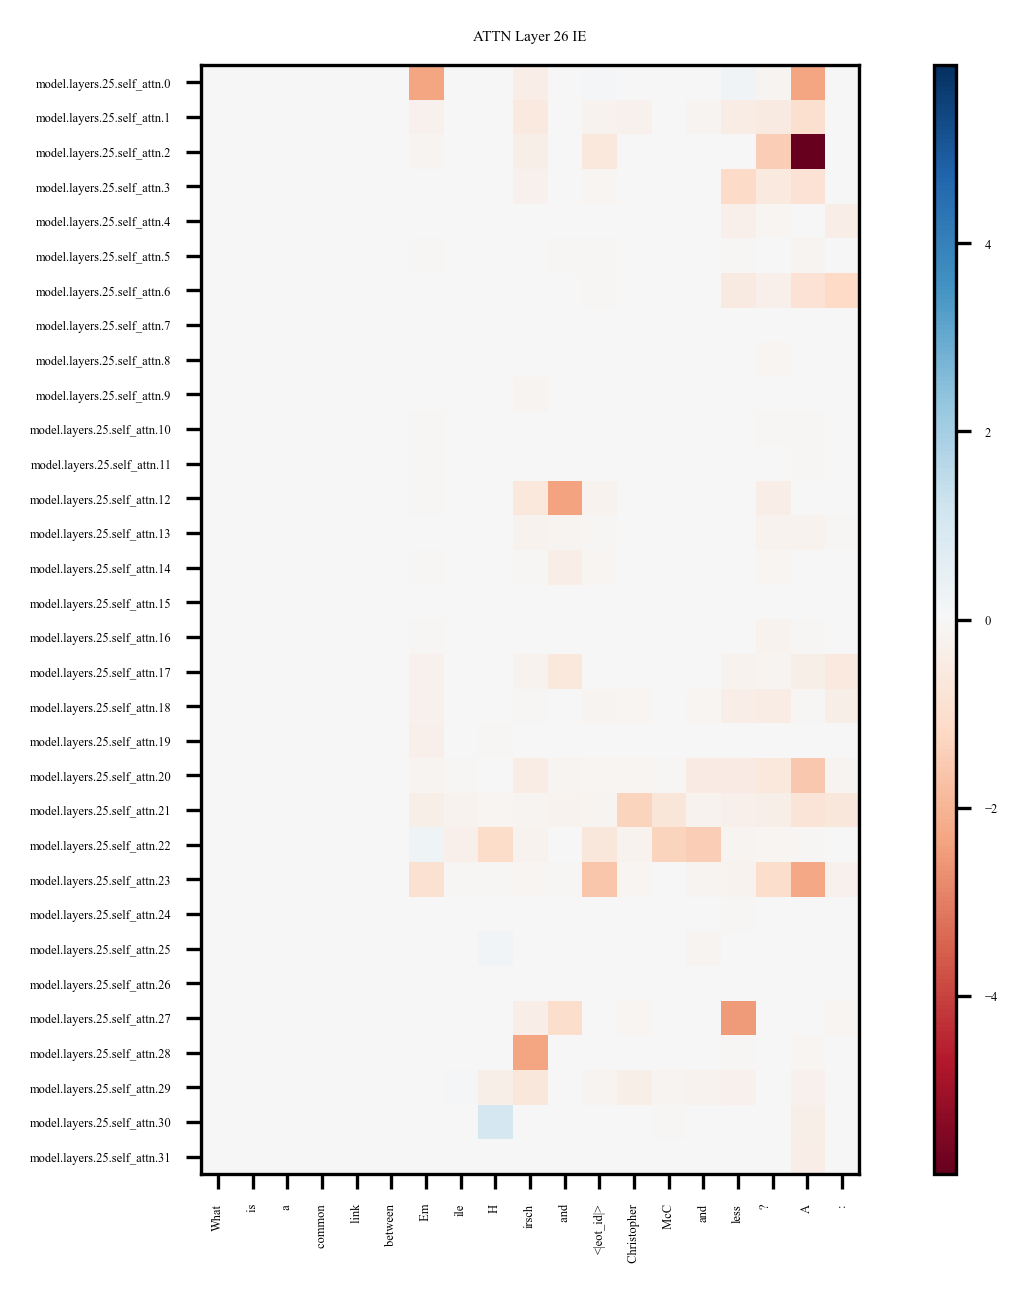

2024-08-14 12:44:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294a72e450>


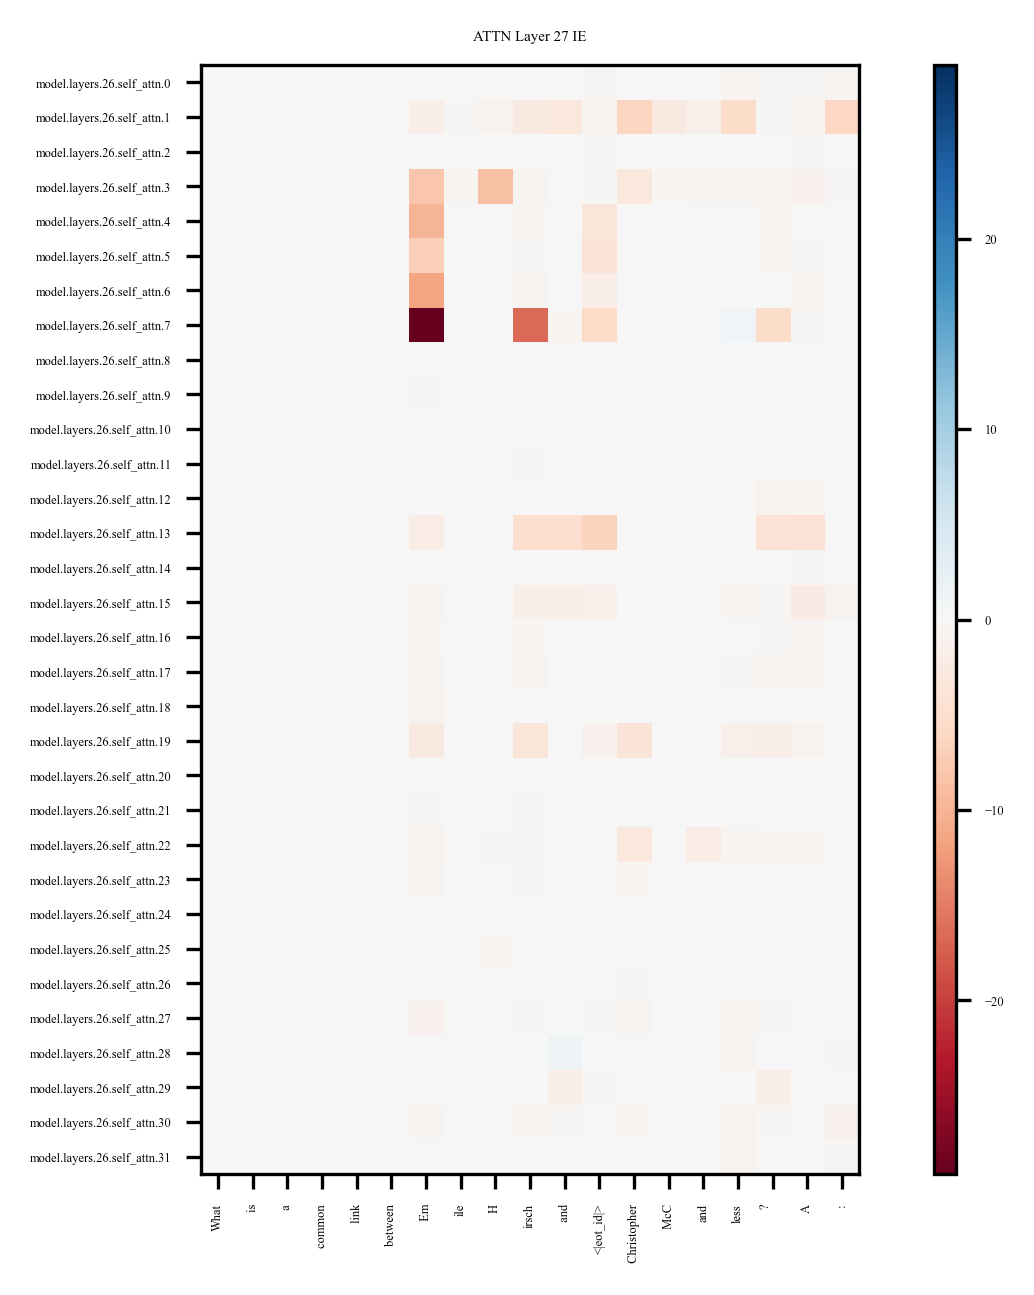

2024-08-14 12:44:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f2a3a087210>


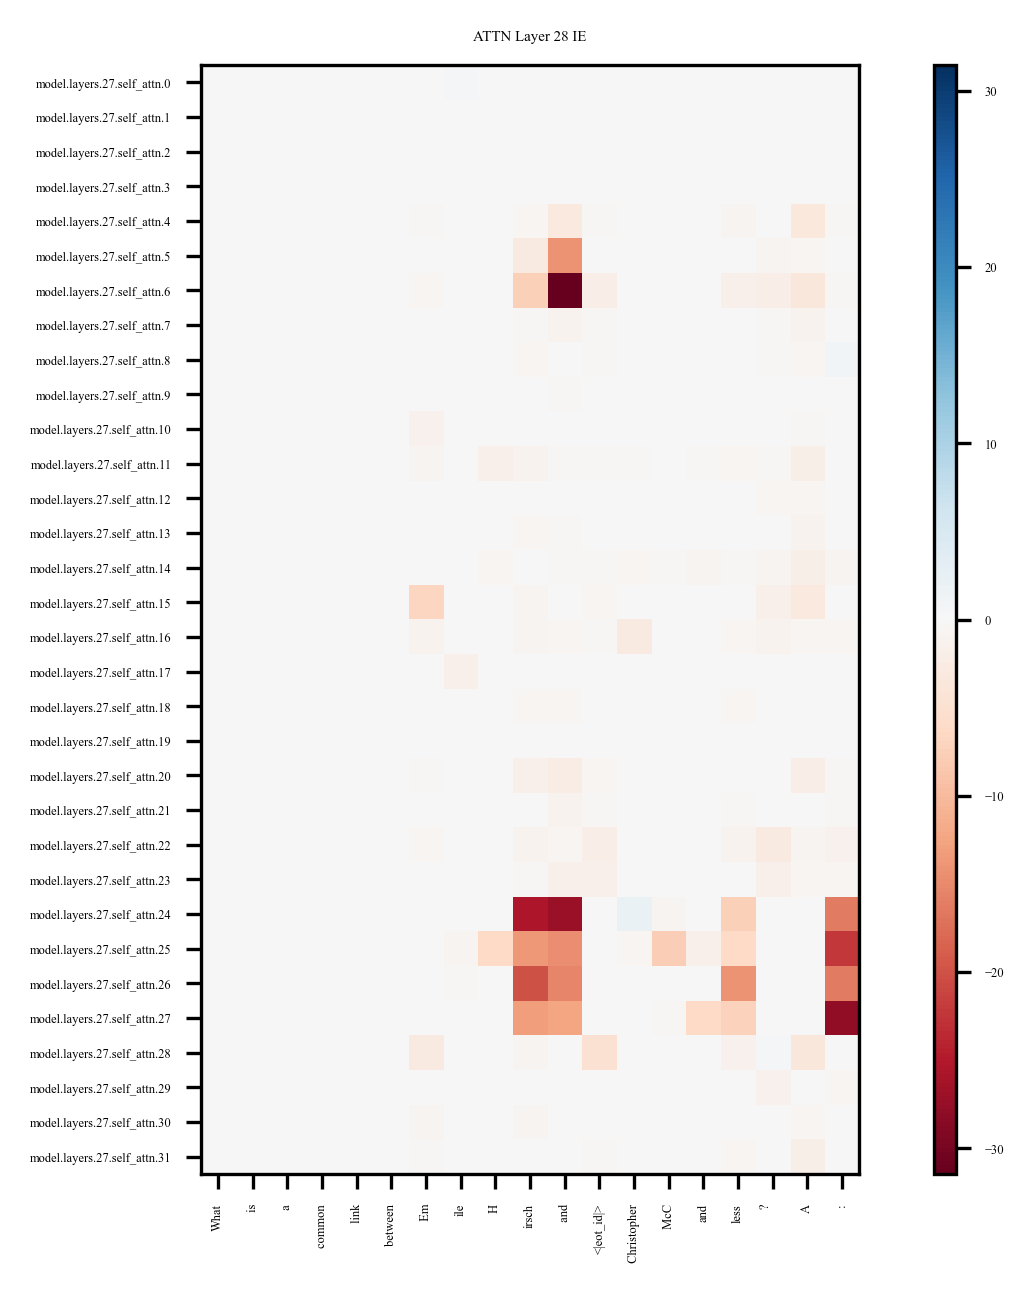

2024-08-14 12:44:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294a40e590>


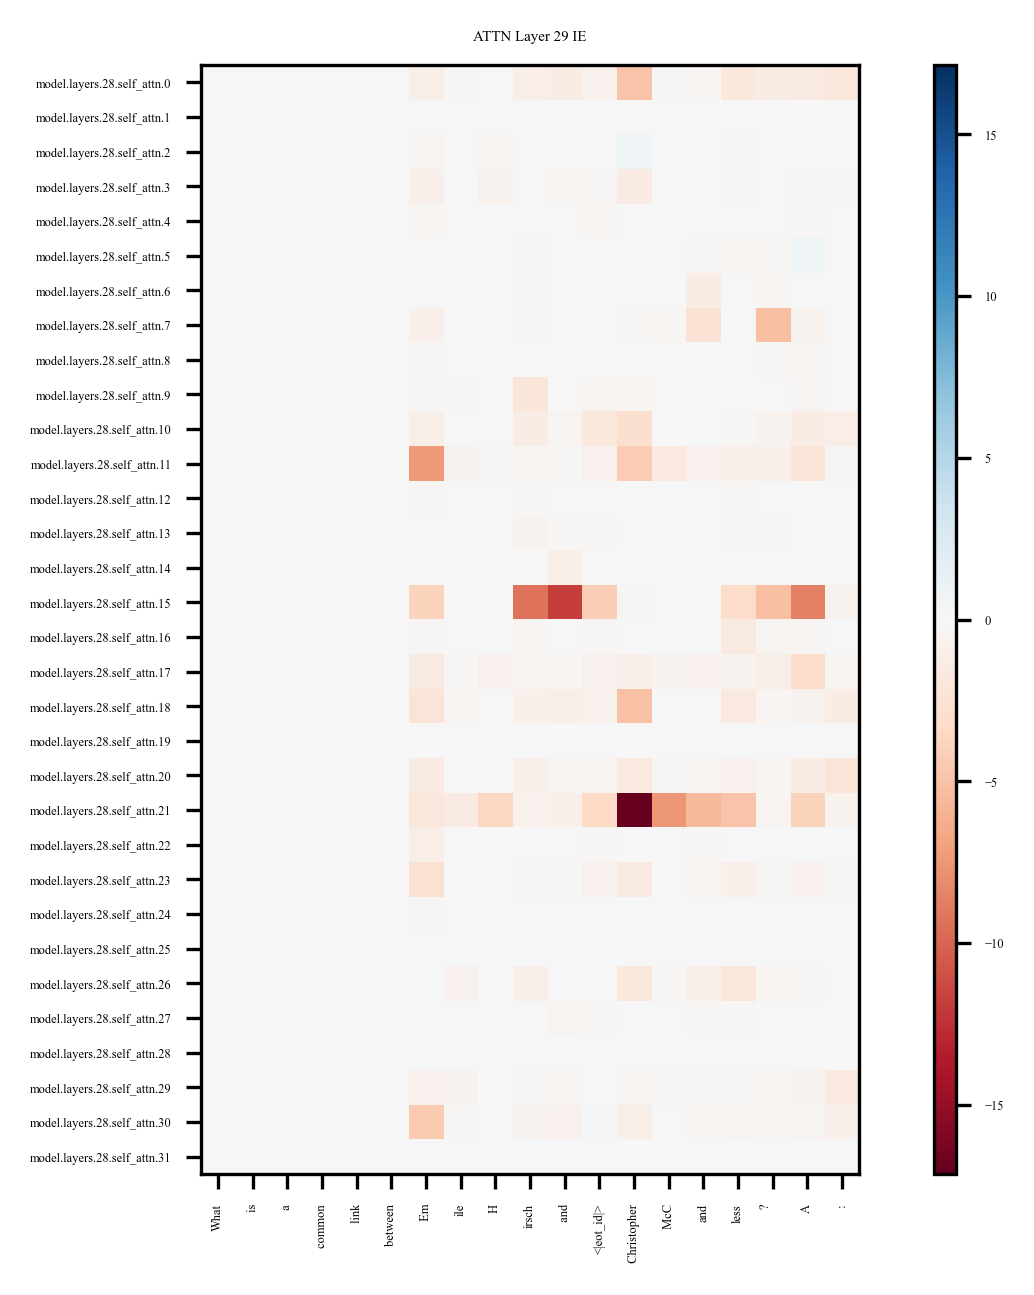

2024-08-14 12:44:04 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f2a3a013850>


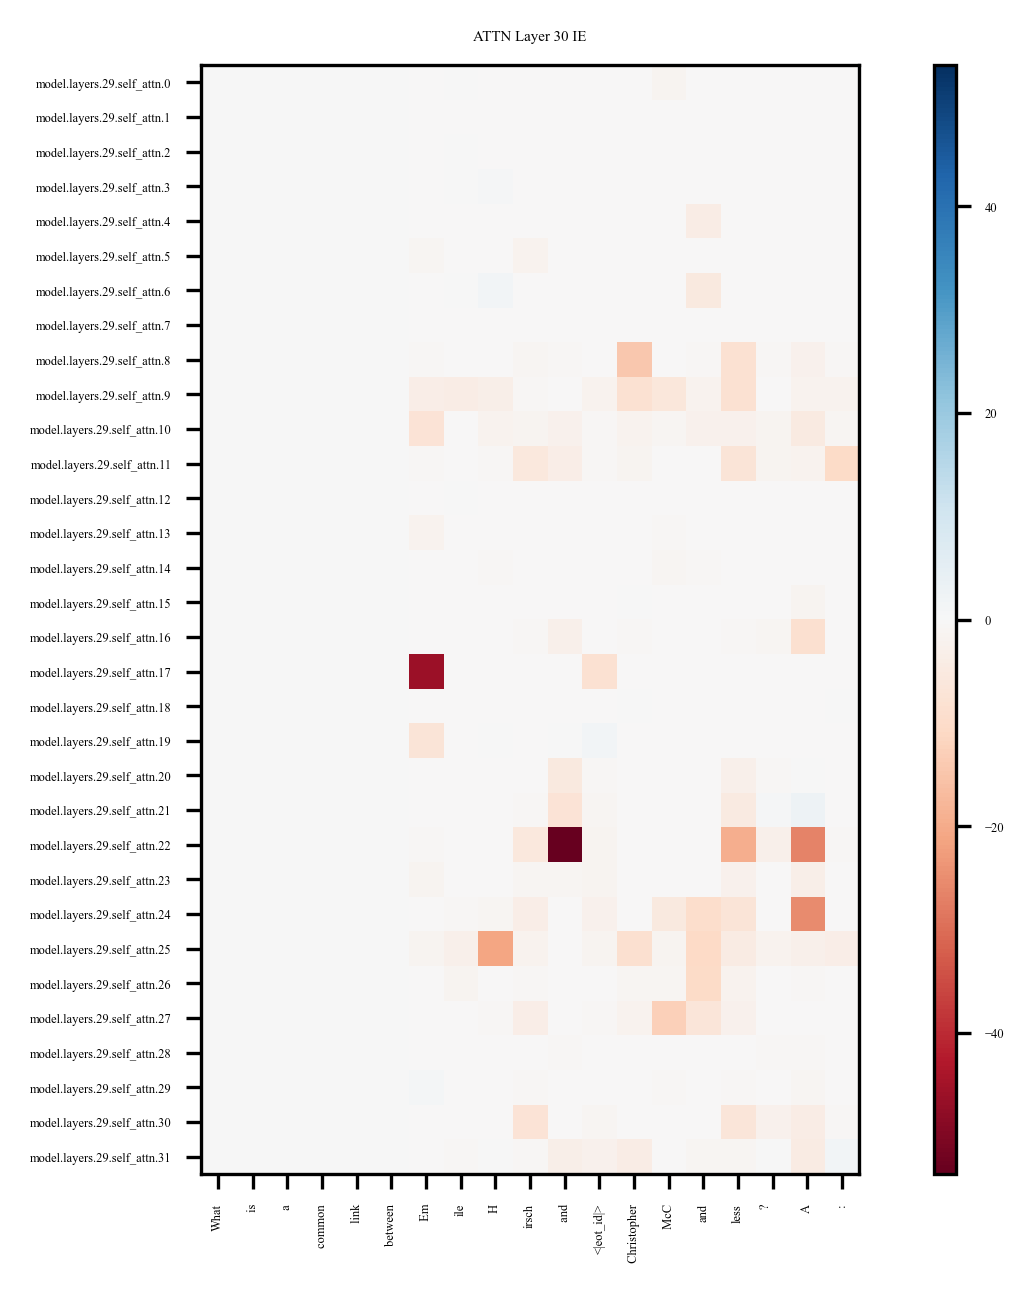

2024-08-14 12:44:05 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294a28f490>


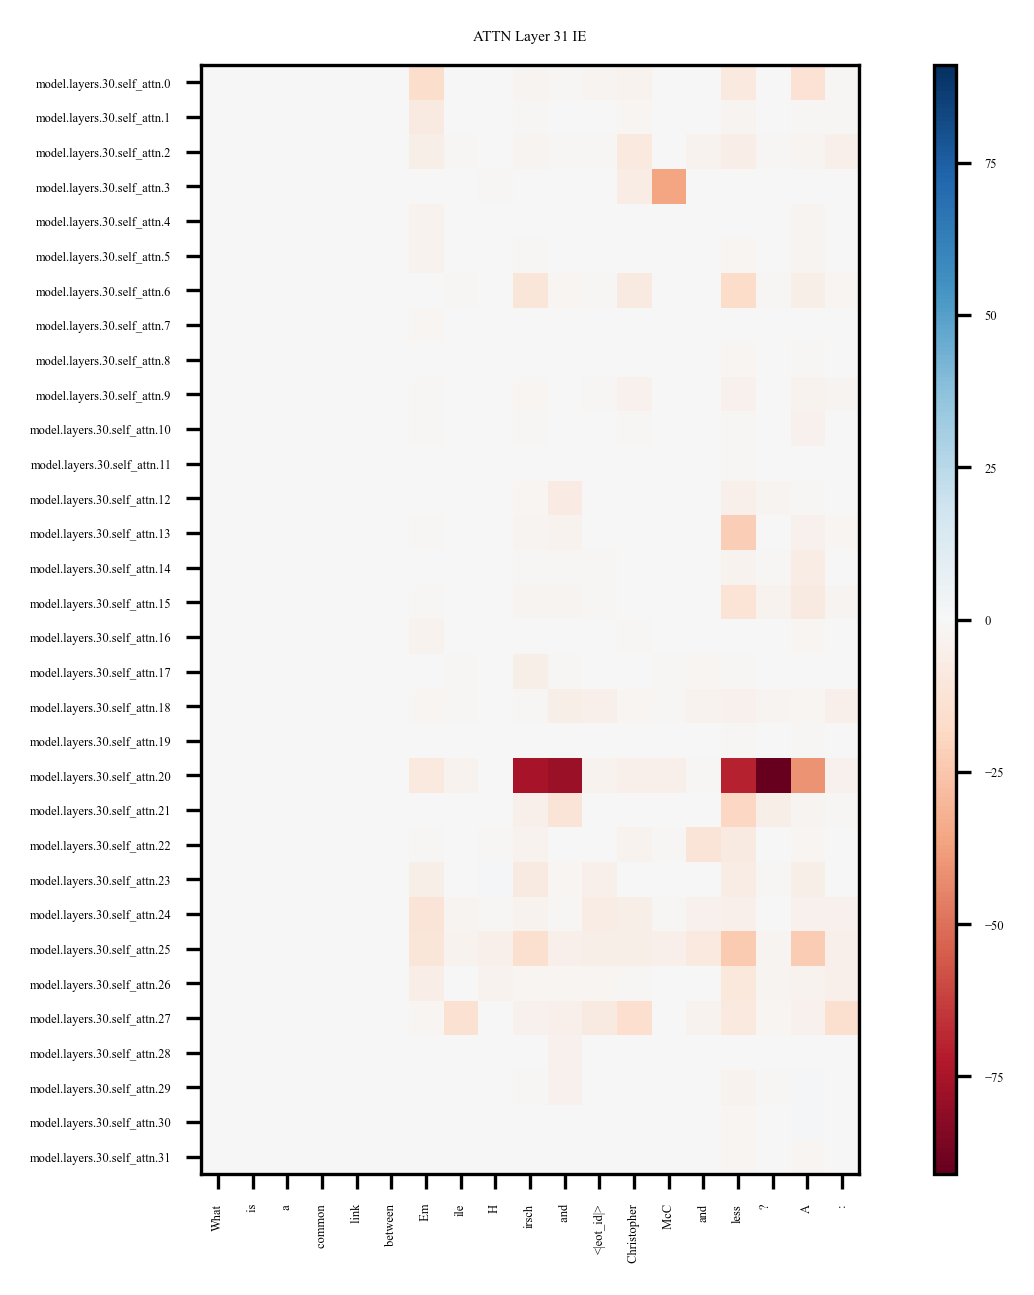

2024-08-14 12:44:05 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f294a105d90>


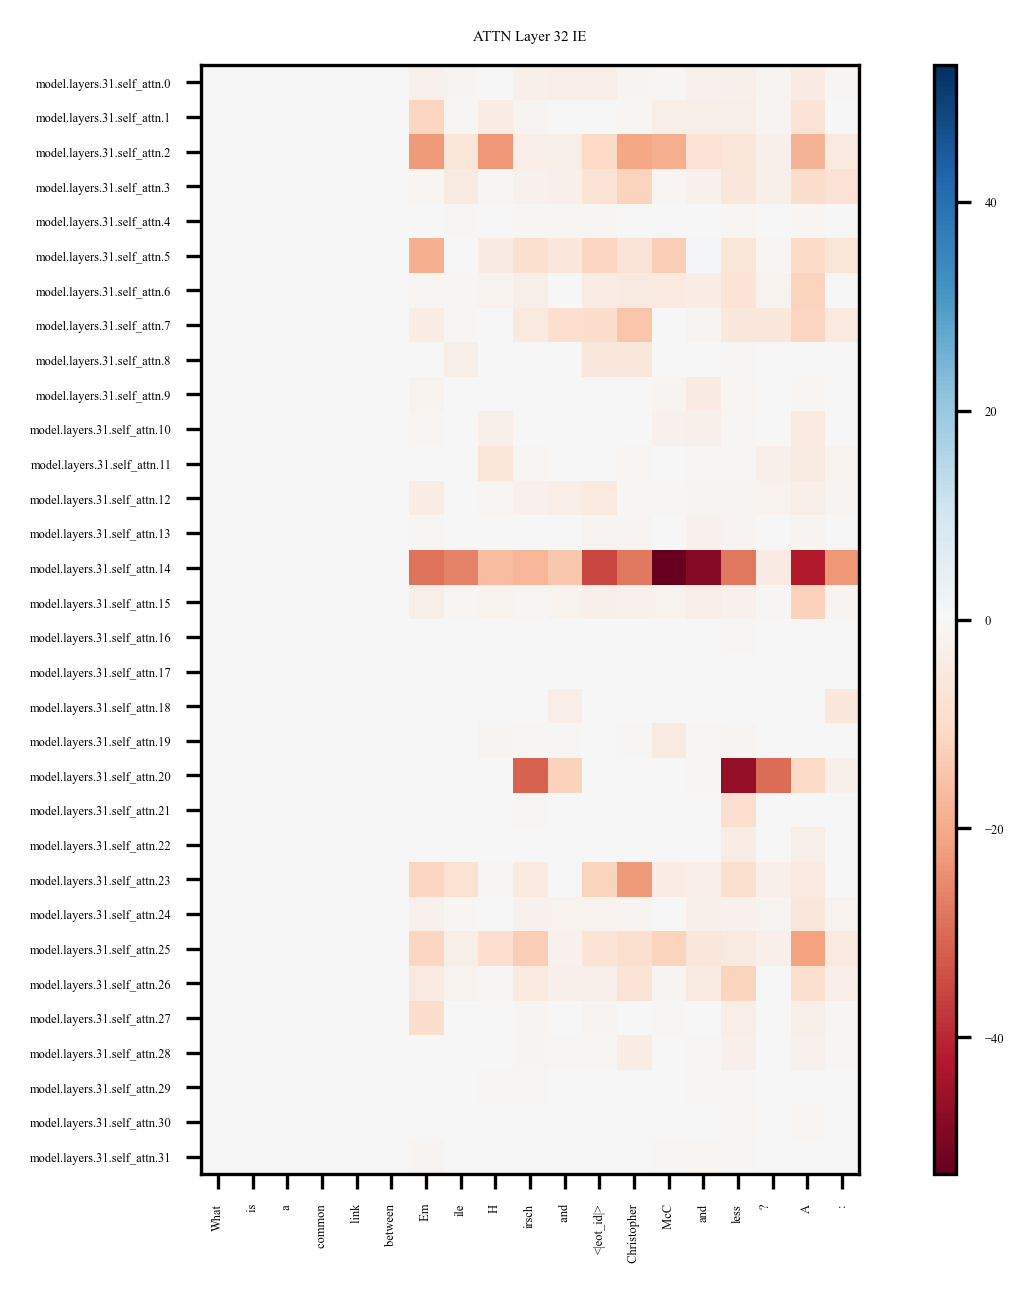

In [38]:
x_labels = [mt.tokenizer.decode(tok) for tok in patch_inputs.input_ids[0][query_start:]]
save_dir = os.path.join(env_utils.DEFAULT_RESULTS_DIR, "head_aie", relation_icq.name)
save_dir = os.path.join(save_dir, "---".join(dataset.examples[patch_idx].entity_pair))

os.makedirs(save_dir, exist_ok=True)

for l_idx in range(mt.n_layer):
    approx_effects, y_labels = get_layerwise_head_contributions(l_idx)
    plot_head_indirect_effect(
        l_idx, x_labels, y_labels, approx_effects,
        # save_pdf=os.path.join(save_dir, f"layer_{l_idx+1}.pdf")
    )
    

In [ ]:
mt

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb

In [ ]:
mt.attn_module_name_format

'model.layers.{}.self_attn'